In [1]:
import numpy as np 
import pandas as pd 
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [25]:
# paths
RESULTS_DIR = "./Results/"
DYADIC_COND = "Dyadic"
SINGLE_COND = "Single"
SINGLEC_COND = "SingleC"
EXPLORE_COND = "Exploration"

DYADIC_PAIR_MAP = { # Leader : Follower
    '1021' : '1022',
    '1023' : '1013',
    '1005' : '1055',
    '1074' : '1069',
    '1008' : '1058',
    '1054' : '1004',
    '1011' : '1017',
    '1018' : '1057'
}

UNIQUE_PATH_LABELS_A = {
    0 : "A_0",
    1 : "A_1_B_9",
    2 : "A_2_B_8",
    3 : "A_3_B_7",
    4 : "A_4_B_6",
    5 : "A_5_B_5",
    6 : "A_6_B_4",
    7 : "A_7_B_3",
    8 : "A_8_B_2",
    9 : "A_9_B_1",
}

UNIQUE_PATH_LABELS_B = {
    9 : "A_1_B_9",
    8 : "A_2_B_8",
    7 : "A_3_B_7",
    6 : "A_4_B_6",
    5 : "A_5_B_5",
    4 : "A_6_B_4",
    3 : "A_7_B_3",
    2 : "A_8_B_2",
    1 : "A_9_B_1",
    0 : "B_0"
}

SINGLE_PERF_PATH = "./Results/Single/Single_Performance_Analysis.csv"
SINGLEC_PERF_PATH = "./Results/SingleC/SingleC_Performance_Analysis.csv"
DYADIC_PERF_PATH = "./Results/Dyadic/Dyadic_Performance_Analysis.csv"

RICH_CLUB_HOUSES = "./Results/Graphs/RichClubHouses_df.csv"


SAVE_PATH = "./Results/ConditionFixDiffs/"


# Preprocessing

### Read interpolation CSVs
And remove rows that are not fixations, i.e. rows with a time difference < 0.2333s.

In [3]:
# read raw files 
interpolation_csv_dict = {}

for condition in [DYADIC_COND, SINGLE_COND, SINGLEC_COND, EXPLORE_COND]:
    
    # add main key if not present
    if not condition in interpolation_csv_dict:
        interpolation_csv_dict[condition] = {}
    
    # read list of files 
    path_cond = "." if condition == EXPLORE_COND else condition
    file_list = glob.glob(RESULTS_DIR + path_cond + "/*interpolation_df.csv")
    
    # load each file and add to dict 
    for file_path in file_list:
        
        # extract subject id 
        subject_id = int(file_path.split("/")[-1].split("_")[0])
        
        # read file 
        df = pd.read_csv(file_path)
        
        # add column for subject id and condition 
        df["subject_id"] = subject_id
        df["condition"] = condition
        
        # remove all non-fixation rows
        df = df[df["timeDiff"] >= 0.2333].reset_index(drop=True)
        
        # add to dict 
        interpolation_csv_dict[condition][subject_id] = df


###  Combine read CSVs into DataFrames for each condition 
Such that samples (and timediffs) are summed up per ColliderName for each individual PathNumber (or only ColliderName in case of the exploration). 

In [4]:
# create df for single pathfinding condition with summed up samples/ timediffs grouped by pathnumber and collidername 
single_cond_df = pd.DataFrame(columns=["PathNumber","ColliderName","Samples","timeDiff","subject_id"])

for subj_id in interpolation_csv_dict[SINGLE_COND].keys():
    curr_df = interpolation_csv_dict[SINGLE_COND][subj_id].groupby(["PathNumber","ColliderName"]).sum().drop(columns=["HMD_x","HMD_y","HMD_z","subject_id","Index"]).reset_index()
    curr_df["subject_id"] = subj_id
    single_cond_df = single_cond_df.append(curr_df)
    
single_cond_df = single_cond_df.reset_index(drop=True)


# create df for singlec pathfinding condition with summed up samples/ timediffs grouped by pathnumber and collidername 
singlec_cond_df = pd.DataFrame(columns=["PathNumber","ColliderName","Samples","timeDiff","subject_id"])

for subj_id in interpolation_csv_dict[SINGLEC_COND].keys():
    curr_df = interpolation_csv_dict[SINGLEC_COND][subj_id].groupby(["PathNumber","ColliderName"]).sum().drop(columns=["HMD_x","HMD_y","HMD_z","subject_id","Index"]).reset_index()
    curr_df["subject_id"] = subj_id
    singlec_cond_df = singlec_cond_df.append(curr_df)
    
singlec_cond_df = singlec_cond_df.reset_index(drop=True)


# create df for dyadic pathfinding condition with summed up samples/ timediffs grouped by pathnumber and collidername 
dyadic_cond_df = pd.DataFrame(columns=["PathNumber","ColliderName","Samples","timeDiff","subject_id"])

for subj_id in interpolation_csv_dict[DYADIC_COND].keys():
    curr_df = interpolation_csv_dict[DYADIC_COND][subj_id].groupby(["PathNumber","ColliderName"]).sum().drop(columns=["HMD_x","HMD_y","HMD_z","subject_id","Index"]).reset_index()
    curr_df["subject_id"] = subj_id
    dyadic_cond_df = dyadic_cond_df.append(curr_df)
    
dyadic_cond_df = dyadic_cond_df.reset_index(drop=True)


# create df for exploration condition with summed up samples/ timediffs grouped by collidername 
exploration_cond_df = pd.DataFrame(columns=["ColliderName","Samples","timeDiff","subject_id"])

for subj_id in interpolation_csv_dict[EXPLORE_COND].keys():
    curr_df = interpolation_csv_dict[EXPLORE_COND][subj_id].groupby(["ColliderName"]).sum().drop(columns=["HMD_x","HMD_y","HMD_z","subject_id","Index"]).reset_index()
    curr_df["subject_id"] = subj_id
    exploration_cond_df = exploration_cond_df.append(curr_df)
    
exploration_cond_df = exploration_cond_df.reset_index(drop=True)


print("Single Cond. Columns: " + str(single_cond_df.columns))
print("SingleC Cond. Columns: " + str(singlec_cond_df.columns))
print("Dyadic Cond. Columns: " + str(dyadic_cond_df.columns))
print("Exploration Cond. Columns: " + str(exploration_cond_df.columns))

Single Cond. Columns: Index(['PathNumber', 'ColliderName', 'Samples', 'timeDiff', 'subject_id'], dtype='object')
SingleC Cond. Columns: Index(['PathNumber', 'ColliderName', 'Samples', 'timeDiff', 'subject_id'], dtype='object')
Dyadic Cond. Columns: Index(['PathNumber', 'ColliderName', 'Samples', 'timeDiff', 'subject_id'], dtype='object')
Exploration Cond. Columns: Index(['ColliderName', 'Samples', 'timeDiff', 'subject_id'], dtype='object')


### Read additional meta info CSVs

In [5]:
single_performance_df = pd.read_csv(SINGLE_PERF_PATH)
single_perf_relevant = single_performance_df.drop(columns=single_performance_df.columns.difference(["SubjectID","Condition"])).rename(columns={"SubjectID":"subject_id","Condition":"start_point"})
singlec_performance_df = pd.read_csv(SINGLEC_PERF_PATH)
singlec_perf_relevant = singlec_performance_df.drop(columns=singlec_performance_df.columns.difference(["SubjectID","Condition"])).rename(columns={"SubjectID":"subject_id","Condition":"start_point"})
dyadic_performance_df = pd.read_csv(DYADIC_PERF_PATH)
dyadic_perf_relevant = dyadic_performance_df.drop(columns=dyadic_performance_df.columns.difference(["SubjectID","Condition","Leader?"])).rename(columns={"SubjectID":"subject_id","Condition":"start_point"})

print("Verify Dyadic Leaders & Followers")
print("Dyadic Leaders: \n" + str(dyadic_perf_relevant.loc[dyadic_perf_relevant["Leader?"], "subject_id"].tolist()))
print("Dyadic Followers: \n" + str(dyadic_perf_relevant.loc[~ dyadic_perf_relevant["Leader?"], "subject_id"].tolist()))
print()
print("Single Perf Relevant Columns: " + str(single_perf_relevant.columns.tolist()))
print("SingleC Perf Relevant Columns: " + str(singlec_perf_relevant.columns.tolist()))
print("Dyadic Perf Relevant Columns: " + str(dyadic_perf_relevant.columns.tolist()))



Verify Dyadic Leaders & Followers
Dyadic Leaders: 
[1005, 1008, 1011, 1018, 1021, 1023, 1054, 1074]
Dyadic Followers: 
[1004, 1013, 1017, 1022, 1055, 1057, 1058, 1069]

Single Perf Relevant Columns: ['subject_id', 'start_point']
SingleC Perf Relevant Columns: ['subject_id', 'start_point']
Dyadic Perf Relevant Columns: ['subject_id', 'start_point', 'Leader?']


### Add info to the data & create combined dataframe
* Group samples and timediff together for each collider of each path of each subject for each condition.
* For all conditions, add route startpoint A or B. 
* For dyadic add follower or leader.

In [6]:
# single
single_cond_processed = single_cond_df.copy(deep=True)
single_cond_processed["Samples"] = pd.to_numeric(single_cond_processed["Samples"]) # otherwise column will be lost 
single_cond_processed = single_cond_processed.groupby(["subject_id","PathNumber","ColliderName"]).sum().reset_index()
single_cond_processed["condition"] = "single"
single_cond_processed = single_cond_processed.merge(single_perf_relevant)

# singlec
singlec_cond_processed = singlec_cond_df.copy(deep=True)
singlec_cond_processed["Samples"] = pd.to_numeric(singlec_cond_processed["Samples"]) # otherwise column will be lost 
singlec_cond_processed = singlec_cond_processed.groupby(["subject_id","PathNumber","ColliderName"]).sum().reset_index()
singlec_cond_processed["condition"] = "singlec"
singlec_cond_processed = singlec_cond_processed.merge(singlec_perf_relevant)

# exploration
exploration_cond_processed = exploration_cond_df.copy(deep=True)
exploration_cond_processed["Samples"] = pd.to_numeric(exploration_cond_processed["Samples"]) # otherwise column will be lost 
exploration_cond_processed = exploration_cond_processed.groupby(["subject_id","ColliderName"]).sum().reset_index()
exploration_cond_processed["condition"] = "exploration"
exploration_cond_processed["PathNumber"] = -1 # indicates path number is not relevant for exploration
exploration_cond_processed["start_point"] = "exploration"

# dyadic
dyadic_cond_processed = dyadic_cond_df.copy(deep=True)
dyadic_cond_processed["Samples"] = pd.to_numeric(dyadic_cond_processed["Samples"]) # otherwise column will be lost 
dyadic_cond_processed = dyadic_cond_processed.groupby(["subject_id","PathNumber","ColliderName"]).sum().reset_index()
dyadic_cond_processed["condition"] = "dyadic"
dyadic_cond_processed = dyadic_cond_processed.merge(dyadic_perf_relevant.drop(columns=["Leader?"]))
dyadic_cond_processed.loc[dyadic_cond_processed["subject_id"].isin(DYADIC_PAIR_MAP.keys()), "condition"] = "dyadic_leader"
dyadic_cond_processed.loc[dyadic_cond_processed["subject_id"].isin(DYADIC_PAIR_MAP.values()), "condition"] = "dyadic_follower"


# combine everything 
full_agg_df = single_cond_processed.append(singlec_cond_processed).append(exploration_cond_processed).append(dyadic_cond_processed)
full_agg_df = full_agg_df.reset_index(drop=True)

# add unique pathnumber 
full_agg_df["unique_path_name"] = np.nan
full_agg_df.loc[(full_agg_df["start_point"] == "A"), "unique_path_name"] = [UNIQUE_PATH_LABELS_A[elem] for elem in full_agg_df.loc[(full_agg_df["start_point"] == "A"), "PathNumber"]]
full_agg_df.loc[(full_agg_df["start_point"] == "B"), "unique_path_name"] = [UNIQUE_PATH_LABELS_B[elem] for elem in full_agg_df.loc[(full_agg_df["start_point"] == "B"), "PathNumber"]]
full_agg_df.loc[(full_agg_df["start_point"] == "exploration"), "unique_path_name"] = "exploration"

full_agg_df = full_agg_df[["subject_id","condition","start_point","PathNumber","unique_path_name","ColliderName","Samples","timeDiff"]] # reorder columns
print("Full aggregated dataframe columns: \n" + str(full_agg_df.columns.tolist()))


Full aggregated dataframe columns: 
['subject_id', 'condition', 'start_point', 'PathNumber', 'unique_path_name', 'ColliderName', 'Samples', 'timeDiff']


### Create dataframe with relative Samples / TimeDiff
* As a very first step: Remove path 0 (test path per session). 
* Do so by dividing Samples / TimeDiff by the total amount per path (per condition, per subject, per start point). 
* Exploration is treated as one path per subject. 
* Created column "rel_samples_from_all": Relative hits are calculated from all hits including e.g. NoHouse hits.
* Created column "rel_samples_no_avatars": Relative hits calculated from all hits excluding avatar hits.
* Created column: "rel_samples_from_buildings": Only house hits are used, so e.g. no house collider hits are excluded before calculating relative amounts.

Total relative numbers: All relative samples within one path add to 1, 9 Paths (excluding Test Path), 10 SingleC + 26 Single + 16 Dyadic = 52 runs (excluding exploration); 9 * 52 = 468 (with 10 paths and exploration: (9+1) * 52 + 26 = 546 )

In [7]:
# function to apply to each group to make samples and timediff relative per path 
def apply_make_relative_df(x, target_samples_name, target_timediff_name):
    x[target_samples_name] = x["Samples"] / x["Samples"].sum()
    x[target_timediff_name] = x["timeDiff"] / x["timeDiff"].sum()
    return x

# init 
rel_agg_df = full_agg_df.copy(deep=True)

# remove path 0 (test paths)
rel_agg_df = rel_agg_df[rel_agg_df["PathNumber"] != 0].reset_index(drop=True)

# make df relative per path: Find all fixations per path and divide by that each samples and timediff value, include hits other than houses 
rel_agg_df = rel_agg_df.groupby(["subject_id","condition","start_point","PathNumber"]).apply(lambda x: apply_make_relative_df(x, "rel_samples_per_path_from_all","rel_timediff_per_path_from_all")) 

# make df relative per session 
rel_agg_df = rel_agg_df.groupby(["subject_id","condition","start_point"]).apply(lambda x: apply_make_relative_df(x, "rel_samples_per_session_from_all","rel_timediff_per_session_from_all")) 

# make df relative per condition & start point
rel_agg_df = rel_agg_df.groupby(["condition","start_point"]).apply(lambda x: apply_make_relative_df(x, "rel_samples_per_cond_startpoint_from_all","rel_timediff_per_cond_startpoint_from_all")) 

# make df relative per condition 
rel_agg_df = rel_agg_df.groupby(["condition"]).apply(lambda x: apply_make_relative_df(x, "rel_samples_per_cond_from_all","rel_timediff_per_cond_from_all")) 

# make df relative per pathhumber only 
rel_agg_df = rel_agg_df.groupby(["PathNumber"]).apply(lambda x: apply_make_relative_df(x, "rel_samples_per_path_only_from_all","rel_timediff_per_path_only_from_all")) 

# make df relative per session 
rel_agg_df = rel_agg_df.groupby(["condition","subject_id"]).apply(lambda x: apply_make_relative_df(x, "rel_samples_per_cond_subjectid_from_all","rel_timediff_per_cond_subjectid_from_all")) 





# use houses and other fixations, but exclude Avatar 
exclude_colliders = ["Avatar"]
rel_agg_df = rel_agg_df[(~ rel_agg_df["ColliderName"].isin(exclude_colliders))].reset_index(drop=True) 

# make df relative per path, include all except Avatar hits  
rel_agg_df = rel_agg_df.groupby(["subject_id","condition","start_point","PathNumber"]).apply(lambda x: apply_make_relative_df(x, "rel_samples_per_path_no_avatars","rel_timediff_per_path_no_avatars")) 

# make df relative per session, include all except Avatar hits 
rel_agg_df = rel_agg_df.groupby(["subject_id","condition","start_point"]).apply(lambda x: apply_make_relative_df(x, "rel_samples_per_session_no_avatars","rel_timediff_per_session_no_avatars")) 

# make df relative per condition & start point, include all except Avatar hits 
rel_agg_df = rel_agg_df.groupby(["condition","start_point"]).apply(lambda x: apply_make_relative_df(x, "rel_samples_per_cond_startpoint_no_avatars","rel_timediff_per_cond_startpoint_no_avatars")) 

# make df relative per condition, include all except Avatar hits 
rel_agg_df = rel_agg_df.groupby(["condition"]).apply(lambda x: apply_make_relative_df(x, "rel_samples_per_cond_no_avatars","rel_timediff_per_cond_no_avatars")) 

# make df relative per path only, include all except Avatar hits 
rel_agg_df = rel_agg_df.groupby(["PathNumber"]).apply(lambda x: apply_make_relative_df(x, "rel_samples_per_path_only_no_avatars","rel_timediff_per_path_only_no_avatars")) 

# make df relative per session 
rel_agg_df = rel_agg_df.groupby(["condition","subject_id"]).apply(lambda x: apply_make_relative_df(x, "rel_samples_per_cond_subjectid_no_avatars","rel_timediff_per_cond_subjectid_no_avatars")) 






# use only houses 
exclude_colliders = ["Avatar","Hand","NoHouse","NoHit","Phone"]
rel_agg_df = rel_agg_df[(~ rel_agg_df["ColliderName"].isin(exclude_colliders))].reset_index(drop=True) 

# make df relative per path, include only houses 
rel_agg_df = rel_agg_df.groupby(["subject_id","condition","start_point","PathNumber"]).apply(lambda x: apply_make_relative_df(x, "rel_samples_per_path_from_buildings","rel_timediff_per_path_from_buildings")) 

# make df relative per session, include only houses 
rel_agg_df = rel_agg_df.groupby(["subject_id","condition","start_point"]).apply(lambda x: apply_make_relative_df(x, "rel_samples_per_session_from_buildings","rel_timediff_per_session_from_buildings")) 

# make df relative per condition & start point, include only houses 
rel_agg_df = rel_agg_df.groupby(["condition","start_point"]).apply(lambda x: apply_make_relative_df(x, "rel_samples_per_cond_startpoint_from_buildings","rel_timediff_per_cond_startpoint_from_buildings")) 

# make df relative per condition, include only houses  
rel_agg_df = rel_agg_df.groupby(["condition"]).apply(lambda x: apply_make_relative_df(x, "rel_samples_per_cond_from_buildings","rel_timediff_per_cond_from_buildings")) 

# make df relative per path only, include only houses  
rel_agg_df = rel_agg_df.groupby(["PathNumber"]).apply(lambda x: apply_make_relative_df(x, "rel_samples_per_path_only_from_buildings","rel_timediff_per_path_only_from_buildings")) 

# make df relative per session 
rel_agg_df = rel_agg_df.groupby(["condition","subject_id"]).apply(lambda x: apply_make_relative_df(x, "rel_samples_per_cond_subjectid_from_buildings","rel_timediff_per_cond_subjectid_from_buildings")) 








print("Columns rel_agg_df: " + str(rel_agg_df.columns.tolist()))


Columns rel_agg_df: ['subject_id', 'condition', 'start_point', 'PathNumber', 'unique_path_name', 'ColliderName', 'Samples', 'timeDiff', 'rel_samples_per_path_from_all', 'rel_timediff_per_path_from_all', 'rel_samples_per_session_from_all', 'rel_timediff_per_session_from_all', 'rel_samples_per_cond_startpoint_from_all', 'rel_timediff_per_cond_startpoint_from_all', 'rel_samples_per_cond_from_all', 'rel_timediff_per_cond_from_all', 'rel_samples_per_path_only_from_all', 'rel_timediff_per_path_only_from_all', 'rel_samples_per_cond_subjectid_from_all', 'rel_timediff_per_cond_subjectid_from_all', 'rel_samples_per_path_no_avatars', 'rel_timediff_per_path_no_avatars', 'rel_samples_per_session_no_avatars', 'rel_timediff_per_session_no_avatars', 'rel_samples_per_cond_startpoint_no_avatars', 'rel_timediff_per_cond_startpoint_no_avatars', 'rel_samples_per_cond_no_avatars', 'rel_timediff_per_cond_no_avatars', 'rel_samples_per_path_only_no_avatars', 'rel_timediff_per_path_only_no_avatars', 'rel_sample

### Read Rich Club Houses

In [8]:
rich_club_houses = pd.read_csv(RICH_CLUB_HOUSES,index_col=0).reset_index(drop=True)
rich_club_houses

,House,Frequency
0,Building_154,23
1,TaskBuilding_35,22
2,Building_176,21
3,Building_166,21
4,Building_214,20
5,Building_171,20
6,Building_139,20
7,Building_163,20
8,Building_157,20
9,Building_152,20


# Plotting

### Find top houses

In [9]:
def find_top_houses(df, number_of_top_houses, include_exploration, method = "rel_from_all_overall", rel_other_column = None):
    '''
    Methods: "rel_from_all_overall", "rel_from_buildings_overall", "top_n_per_path"
    
    "top_n_per_path":
    * Find top n buildings per path (per subject, per condition, per start point) based on samples. 
    * Combine the top buildings of all paths (here each building that made it to the top list has the same weight).
    * Take from the combined top buildings the top n buildings based on number of appearence in the top list. 

    "rel_from_all_overall":
    * Combine all relative samples (calculated including the no house etc. hits) and take top n houses.

    "rel_from_no_avatars_overall":
    * Combine all relative samples (calculated with all hits excluding Avatar hits) and take top n houses.

    "rel_from_buildings_overall":
    * Combine all relative samples (calculated with only the houses) and take top n houses. 
    
    "rel_other":
    * Combine all relative samples (from column specified in rel_other_column) and take top n houses.
    
    "absolute_from_all_overall":
    * Combine all samples (actual samples) and take top n houses. 
    '''
    
    # init
    top_houses_df = df.copy(deep=True)
    top_houses_df = top_houses_df.sort_values(['subject_id','condition','start_point','PathNumber','Samples'],ascending=False)

    # exploration? (will likely be weighed little however, since one exploration counts as one path)
    if not include_exploration:
        top_houses_df = top_houses_df[(top_houses_df["condition"] != "exploration")]
        
    # extract top n houses 
    top_house_names = []
    
    
    if method == "rel_from_all_overall":
        top_house_names = list(top_houses_df.groupby("ColliderName").sum().sort_values("rel_samples_per_path_from_all",ascending=False).reset_index().iloc[:number_of_top_houses]["ColliderName"])
    
    elif method == "rel_from_no_avatars_overall":
        top_house_names = list(top_houses_df.groupby("ColliderName").sum().sort_values("rel_samples_per_path_no_avatars",ascending=False).reset_index().iloc[:number_of_top_houses]["ColliderName"])
    
    elif method == "rel_from_buildings_overall":
        top_house_names = list(top_houses_df.groupby("ColliderName").sum().sort_values("rel_samples_per_path_from_buildings",ascending=False).reset_index().iloc[:number_of_top_houses]["ColliderName"])
    
    elif method == "rel_other":
        top_house_names = list(top_houses_df.groupby("ColliderName").sum().sort_values(rel_other_column,ascending=False).reset_index().iloc[:number_of_top_houses]["ColliderName"])
    
    elif method == "absolute_from_all_overall":
        top_house_names = list(top_houses_df.groupby("ColliderName").sum().sort_values("Samples",ascending=False).reset_index().iloc[:number_of_top_houses]["ColliderName"])
    
    elif method == "top_n_per_path":
        
        # find top n houses per group 
        raw_house_entries = top_houses_df.groupby(["subject_id","condition","start_point","PathNumber","ColliderName"]).head(number_of_top_houses)
        raw_house_entries["counter"] = 1

        # combine top n of each group and take from those top n 
        top_house_names = raw_house_entries.groupby("ColliderName").sum().sort_values("counter",ascending=False)
        top_house_names = list(top_house_names[:number_of_top_houses].reset_index()["ColliderName"])
   
    
    
    return top_house_names



In [10]:
# Find top houses (excluding path 0 (test path))
# Across all subjects & conditions & paths
# Use relative samples to not bias towards longer paths here 
top_house_names = find_top_houses(rel_agg_df,30,False,"rel_from_all_overall")
print("Top Houses: \n" + str(top_house_names))

Top Houses: 
['TaskBuilding_1', 'TaskBuilding_39', 'TaskBuilding_44', 'TaskBuilding_29', 'Building_64', 'Building_154', 'Building_176', 'TaskBuilding_46', 'TaskBuilding_11', 'TaskBuilding_9', 'Building_94', 'TaskBuilding_41', 'Church-TaskBuilding_16', 'Building_152', 'TaskBuilding_19', 'Building_186', 'Building_139', 'TaskBuilding_45', 'Windmill-TaskBuilding_10_1', 'TaskBuilding_4', 'TaskBuilding_7', 'TaskBuilding_12', 'Building_220', 'TaskBuilding_14', 'Building_91', 'Building_205', 'Building_229', 'Building_214', 'TaskBuilding_35', 'TaskBuilding_50']


## Most interesting

/Users/stefan/opt/anaconda3/envs/graphs/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator


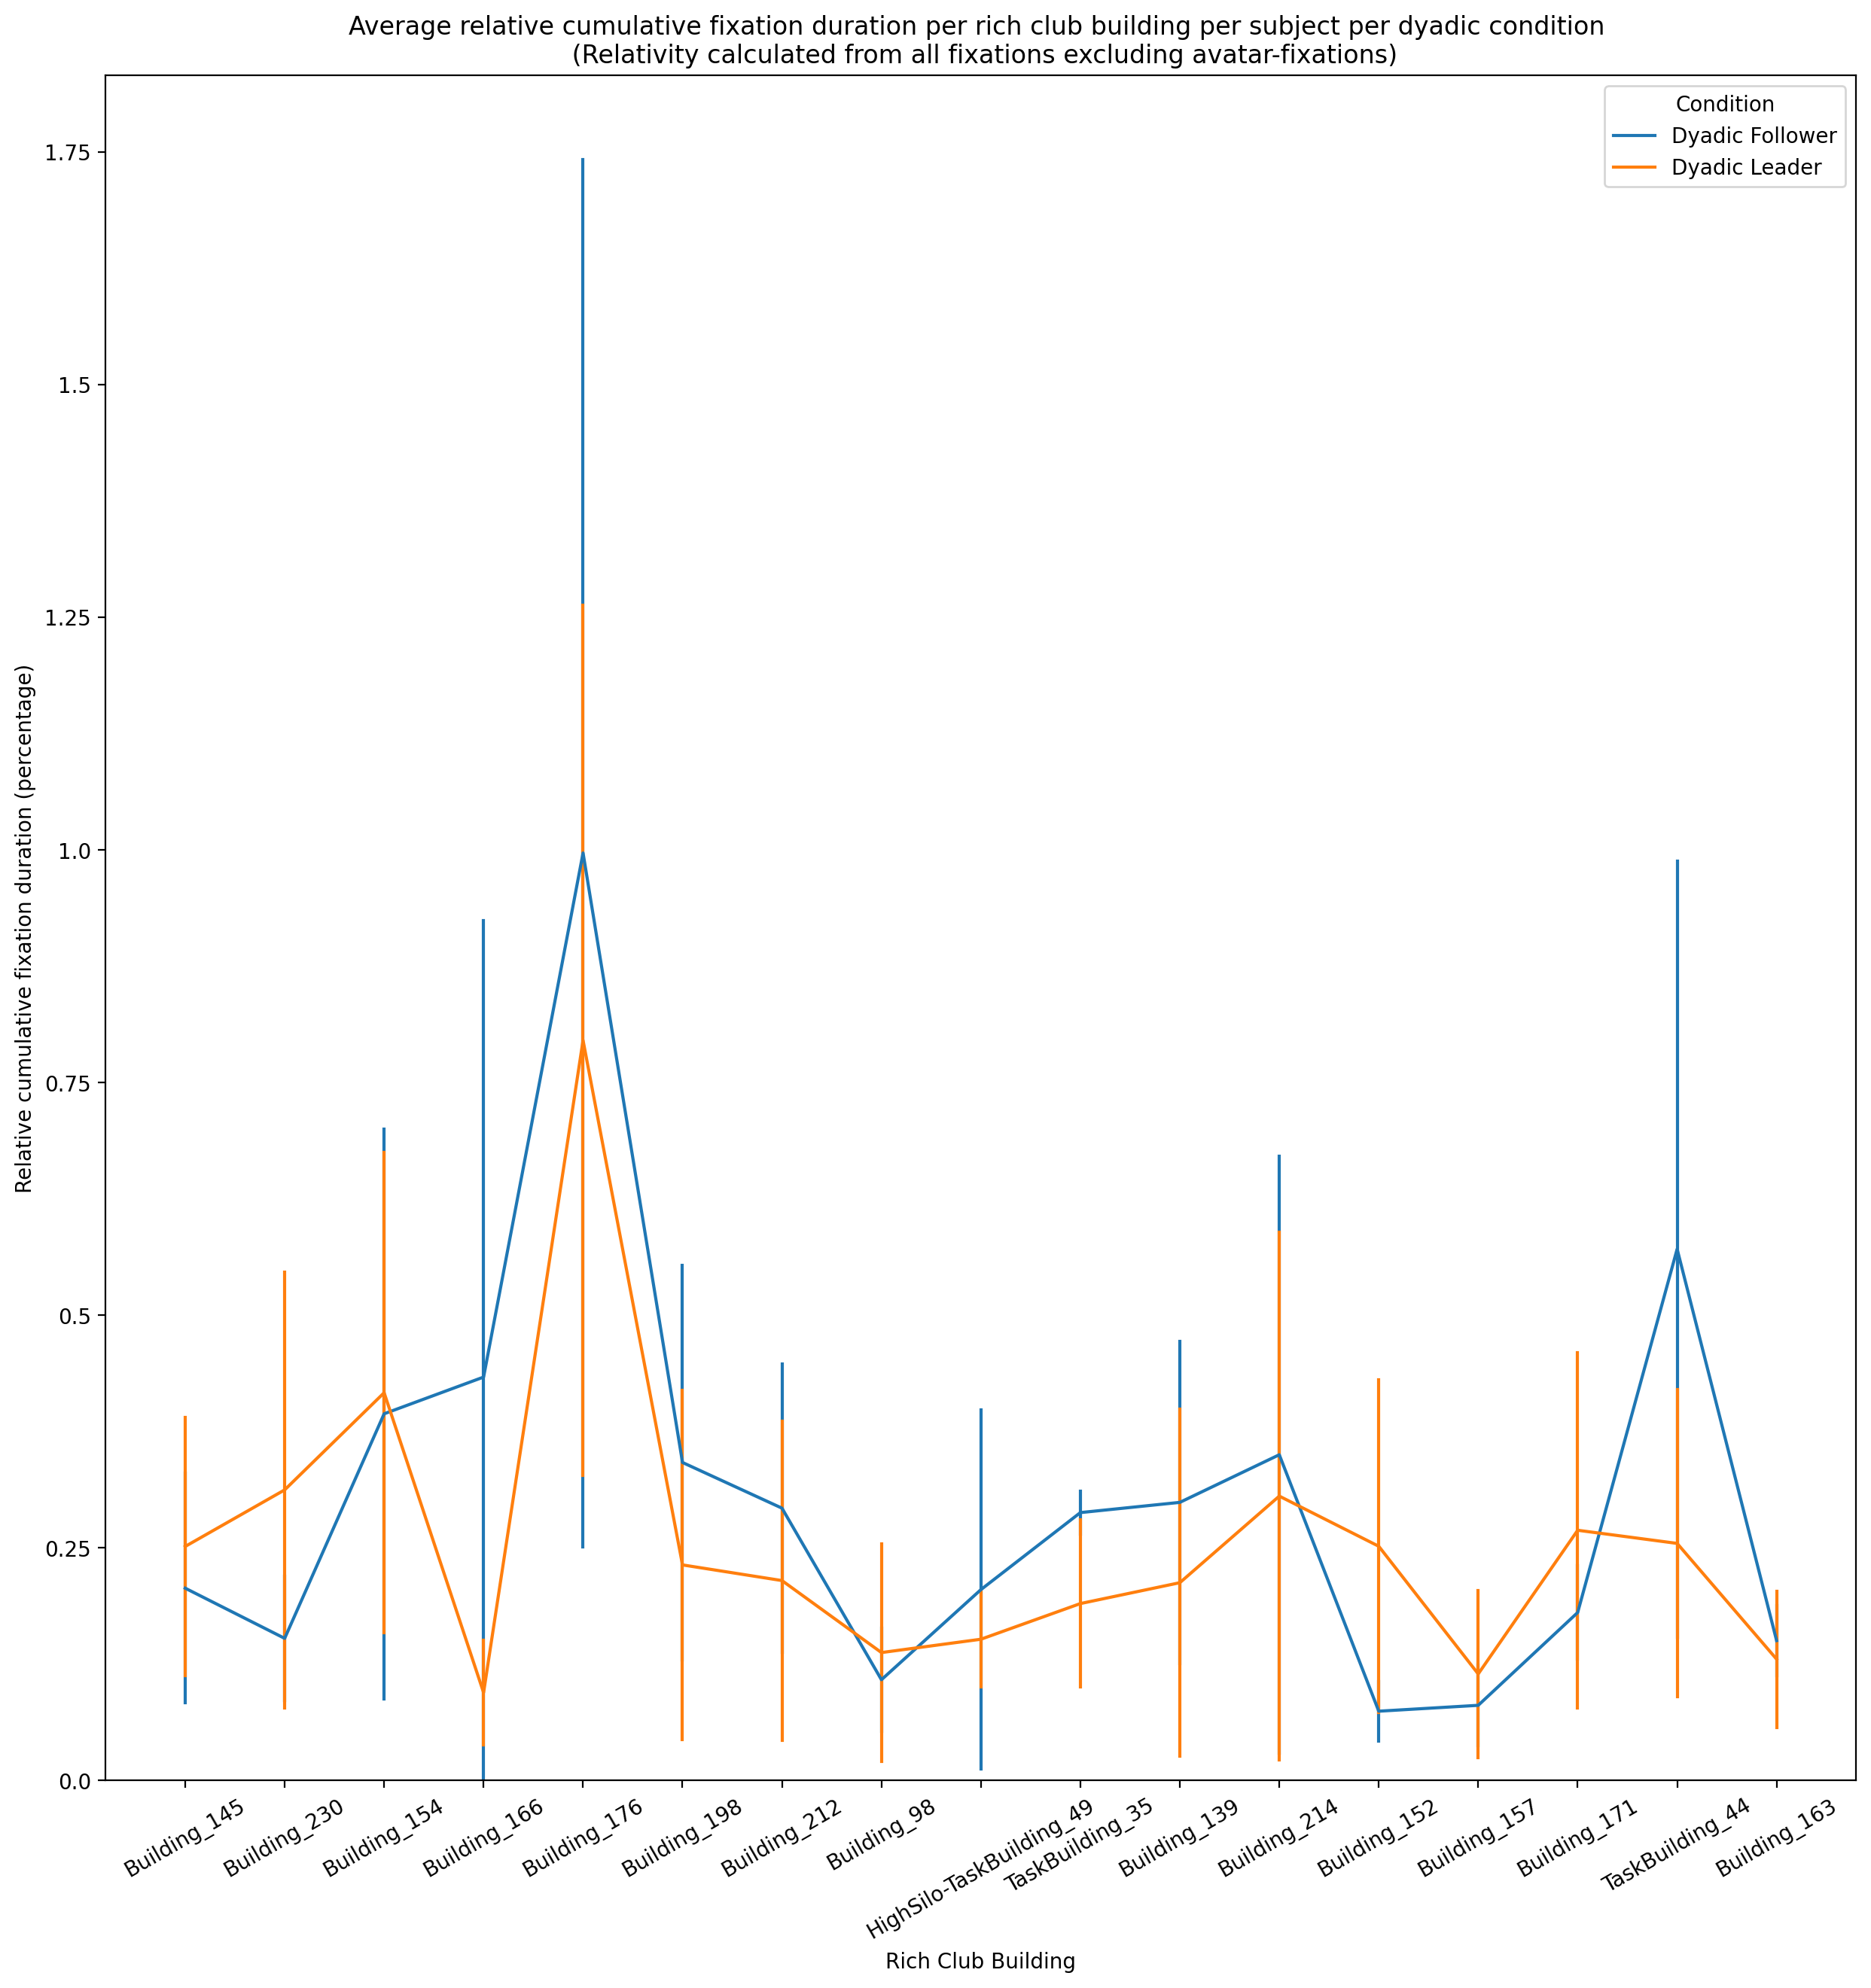

In [31]:
# Only Dyadic Leader and Dyadic Follower, plot for rich club houses  

# Special treatment: 
# Combine entire available data for Leader and Follower.
# Exclude Avatar hits. 
# Plot relative hits per condition & subject on RichClub buildings.


data_df = rel_agg_df.copy(deep=True)

# Use rich club houses & filter data 
special_top_houses = list(rich_club_houses["House"])
data_df = data_df[data_df["ColliderName"].isin(special_top_houses)]

# plot 
fig, ax = plt.subplots(1,1, figsize=(15,15), squeeze = False, dpi=200)

g = sns.lineplot(data=data_df.groupby(["condition","subject_id","ColliderName"]).sum().reset_index(), x="ColliderName", y="rel_timediff_per_cond_subjectid_no_avatars", hue="condition", \
                 hue_order = ["dyadic_follower", "dyadic_leader"], \
                 err_style = "bars", \
                 ci="sd", ax = ax[0,0])

plt.xticks(rotation = 30)
g.set_xlabel("Rich Club Building")

ax[0,0].title.set_text("Average relative cumulative fixation duration per rich club building per subject per dyadic condition \n (Relativity calculated from all fixations excluding avatar-fixations)")

g.set(ylim= (0,None))

ylabels = [str(round(y * 100,2)) for y in g.get_yticks()]
g.set_yticklabels(ylabels)
g.set_ylabel("Relative cumulative fixation duration (percentage)")



legend = ax[0,0].get_legend()
legend_title = 'Condition'
legend_labels = ['Dyadic Follower', 'Dyadic Leader']
legend.set_title(legend_title)
for t, l in zip(legend.texts, legend_labels):
    t.set_text(l)

plt.savefig(SAVE_PATH + 'dy_cond_rich_rel_no_avatars.png')
plt.show()





/Users/stefan/opt/anaconda3/envs/graphs/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator


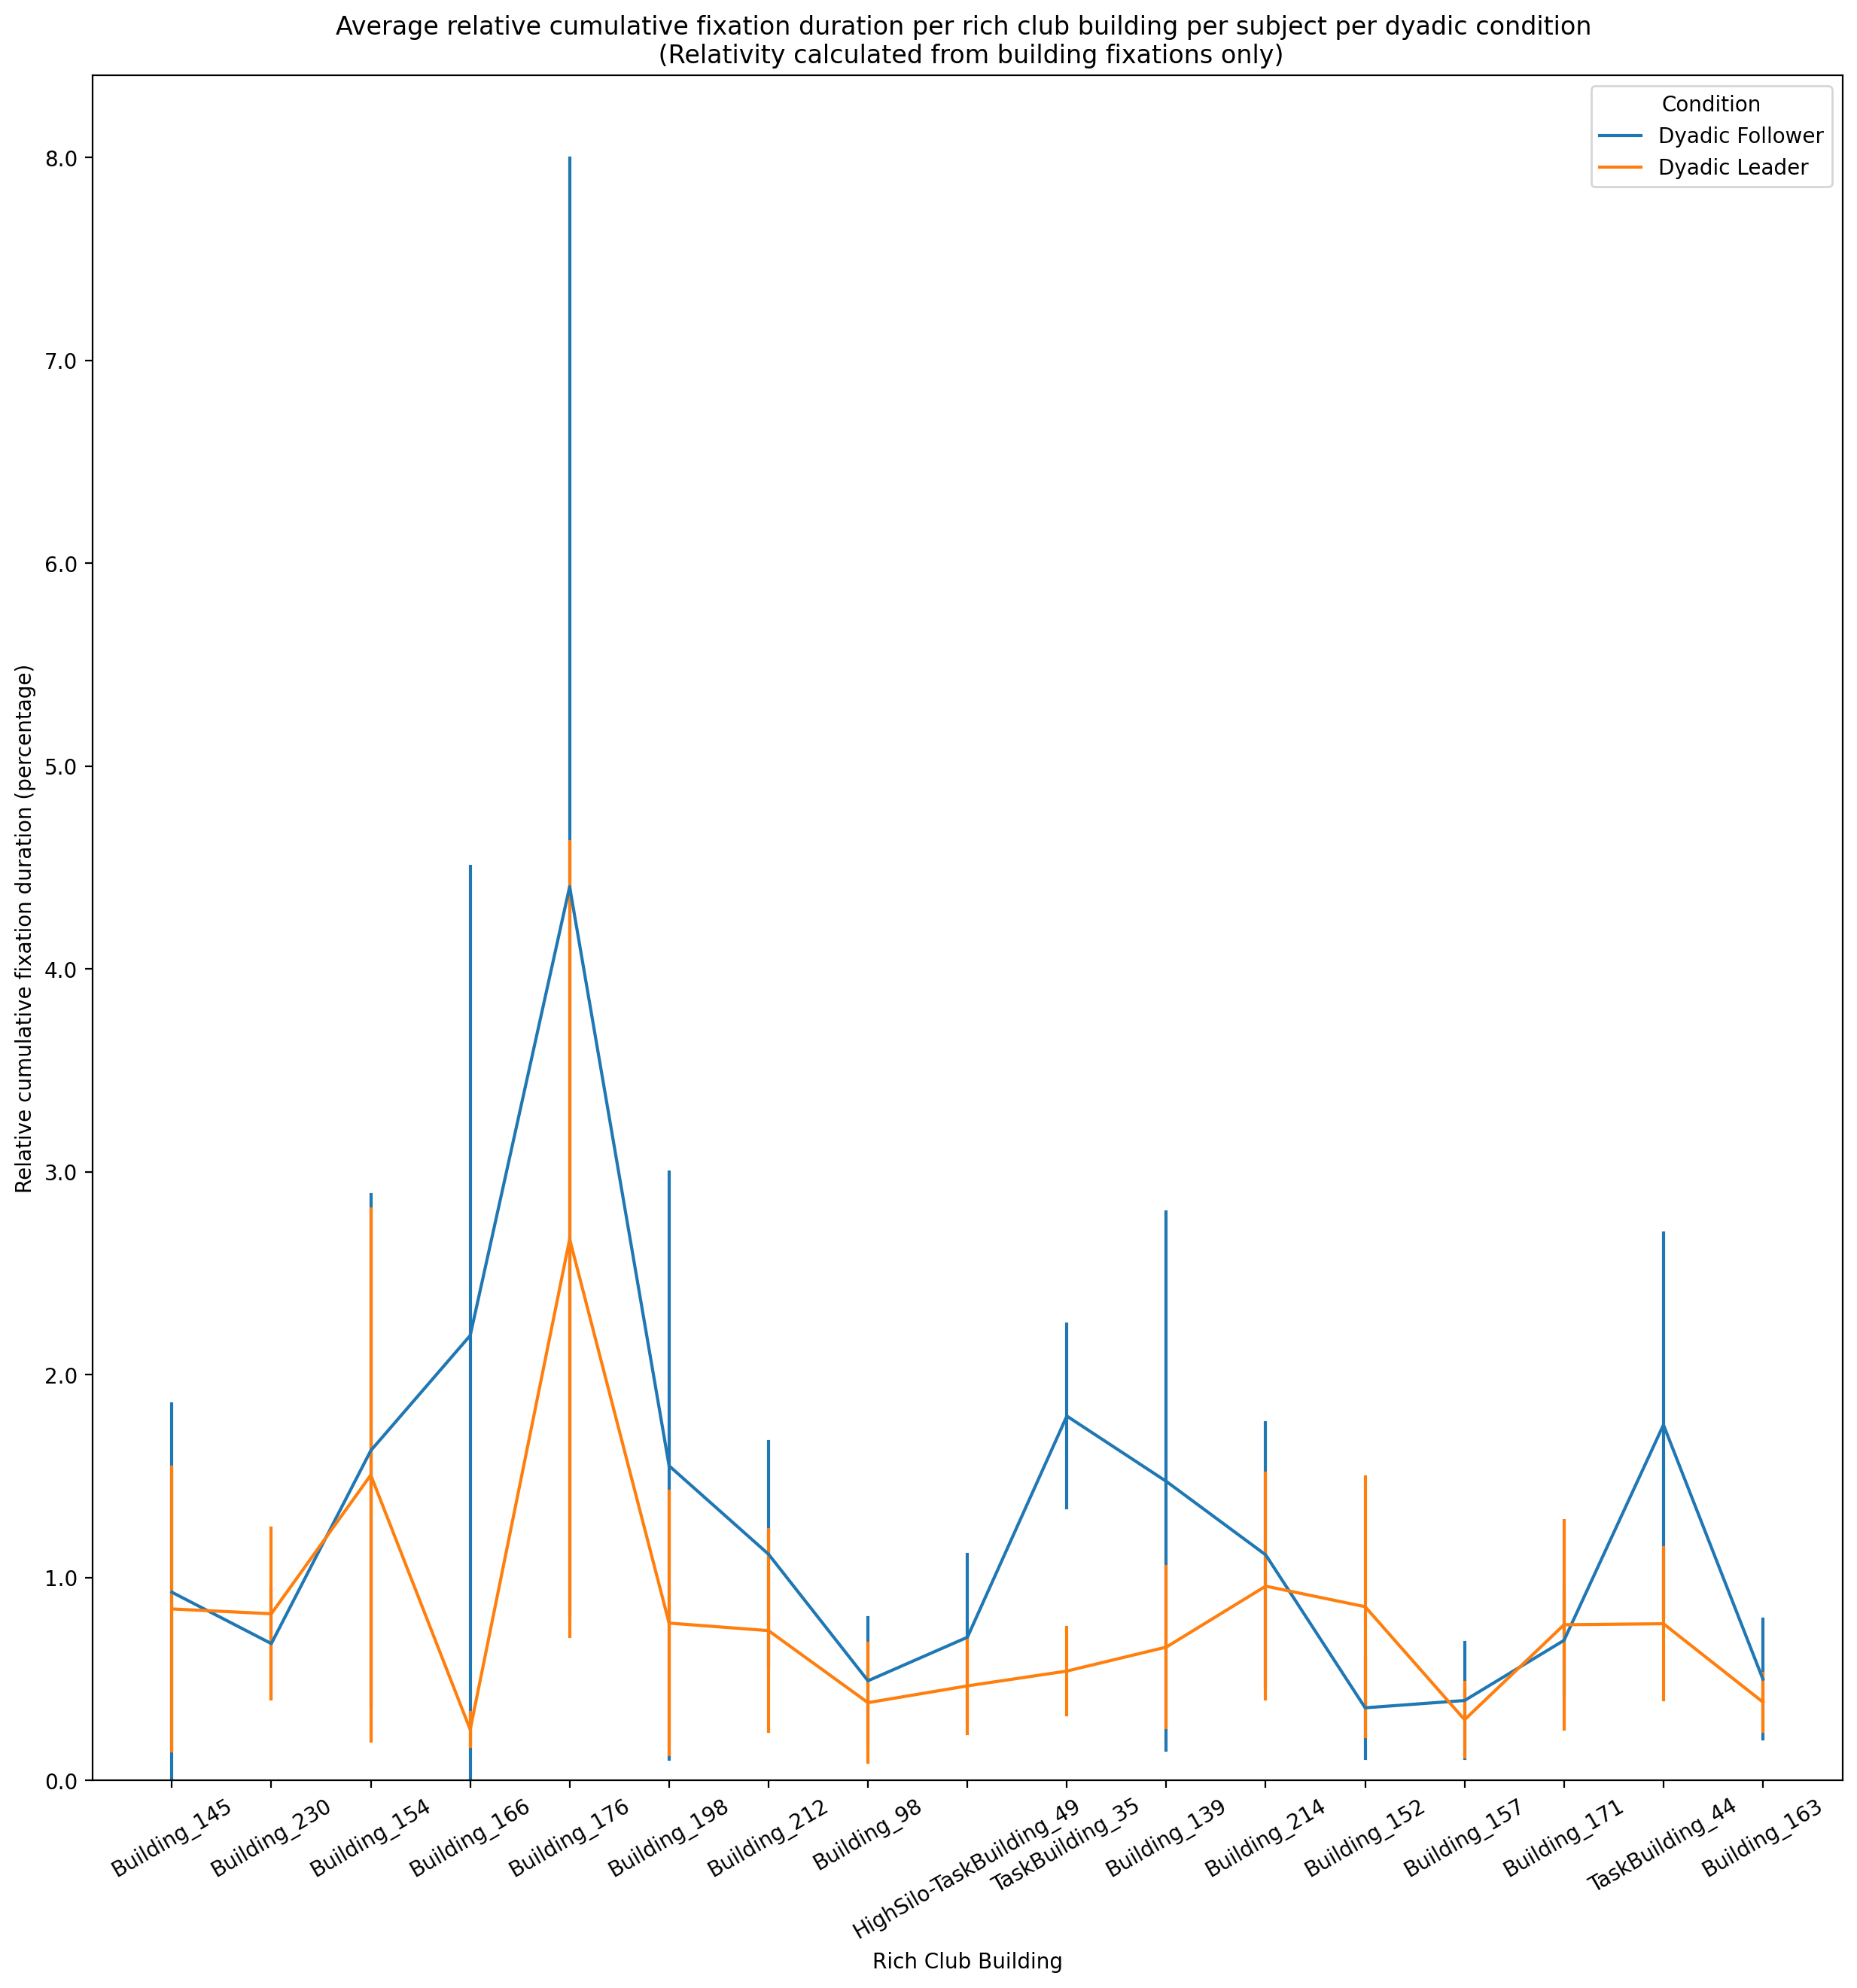

In [30]:
# Only Dyadic Leader and Dyadic Follower, plot for rich club houses  

# Special treatment: 
# Combine entire available data for Leader and Follower.
# Only house hits.
# Plot relative hits per condition & subject on RichClub buildings.


data_df = rel_agg_df.copy(deep=True)

# Use rich club houses & filter data 
special_top_houses = list(rich_club_houses["House"])
data_df = data_df[data_df["ColliderName"].isin(special_top_houses)]

# plot 
fig, ax = plt.subplots(1,1, figsize=(15,15), squeeze = False, dpi=200)

g = sns.lineplot(data=data_df.groupby(["condition","subject_id","ColliderName"]).sum().reset_index(), x="ColliderName", y="rel_timediff_per_cond_subjectid_from_buildings", hue="condition", \
                 hue_order = ["dyadic_follower", "dyadic_leader"], \
                 err_style = "bars", \
                 ci="sd", ax = ax[0,0])

plt.xticks(rotation = 30)
g.set_xlabel("Rich Club Building")

ax[0,0].title.set_text("Average relative cumulative fixation duration per rich club building per subject per dyadic condition \n (Relativity calculated from building fixations only)")

g.set(ylim= (0,None))

ylabels = [str(round(y * 100,2)) for y in g.get_yticks()]
g.set_yticklabels(ylabels)
g.set_ylabel("Relative cumulative fixation duration (percentage)")



legend = ax[0,0].get_legend()
legend_title = 'Condition'
legend_labels = ['Dyadic Follower', 'Dyadic Leader']
legend.set_title(legend_title)
for t, l in zip(legend.texts, legend_labels):
    t.set_text(l)


plt.savefig(SAVE_PATH + 'dy_cond_rich_rel_from_buildings.png')
plt.show()





/Users/stefan/opt/anaconda3/envs/graphs/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator


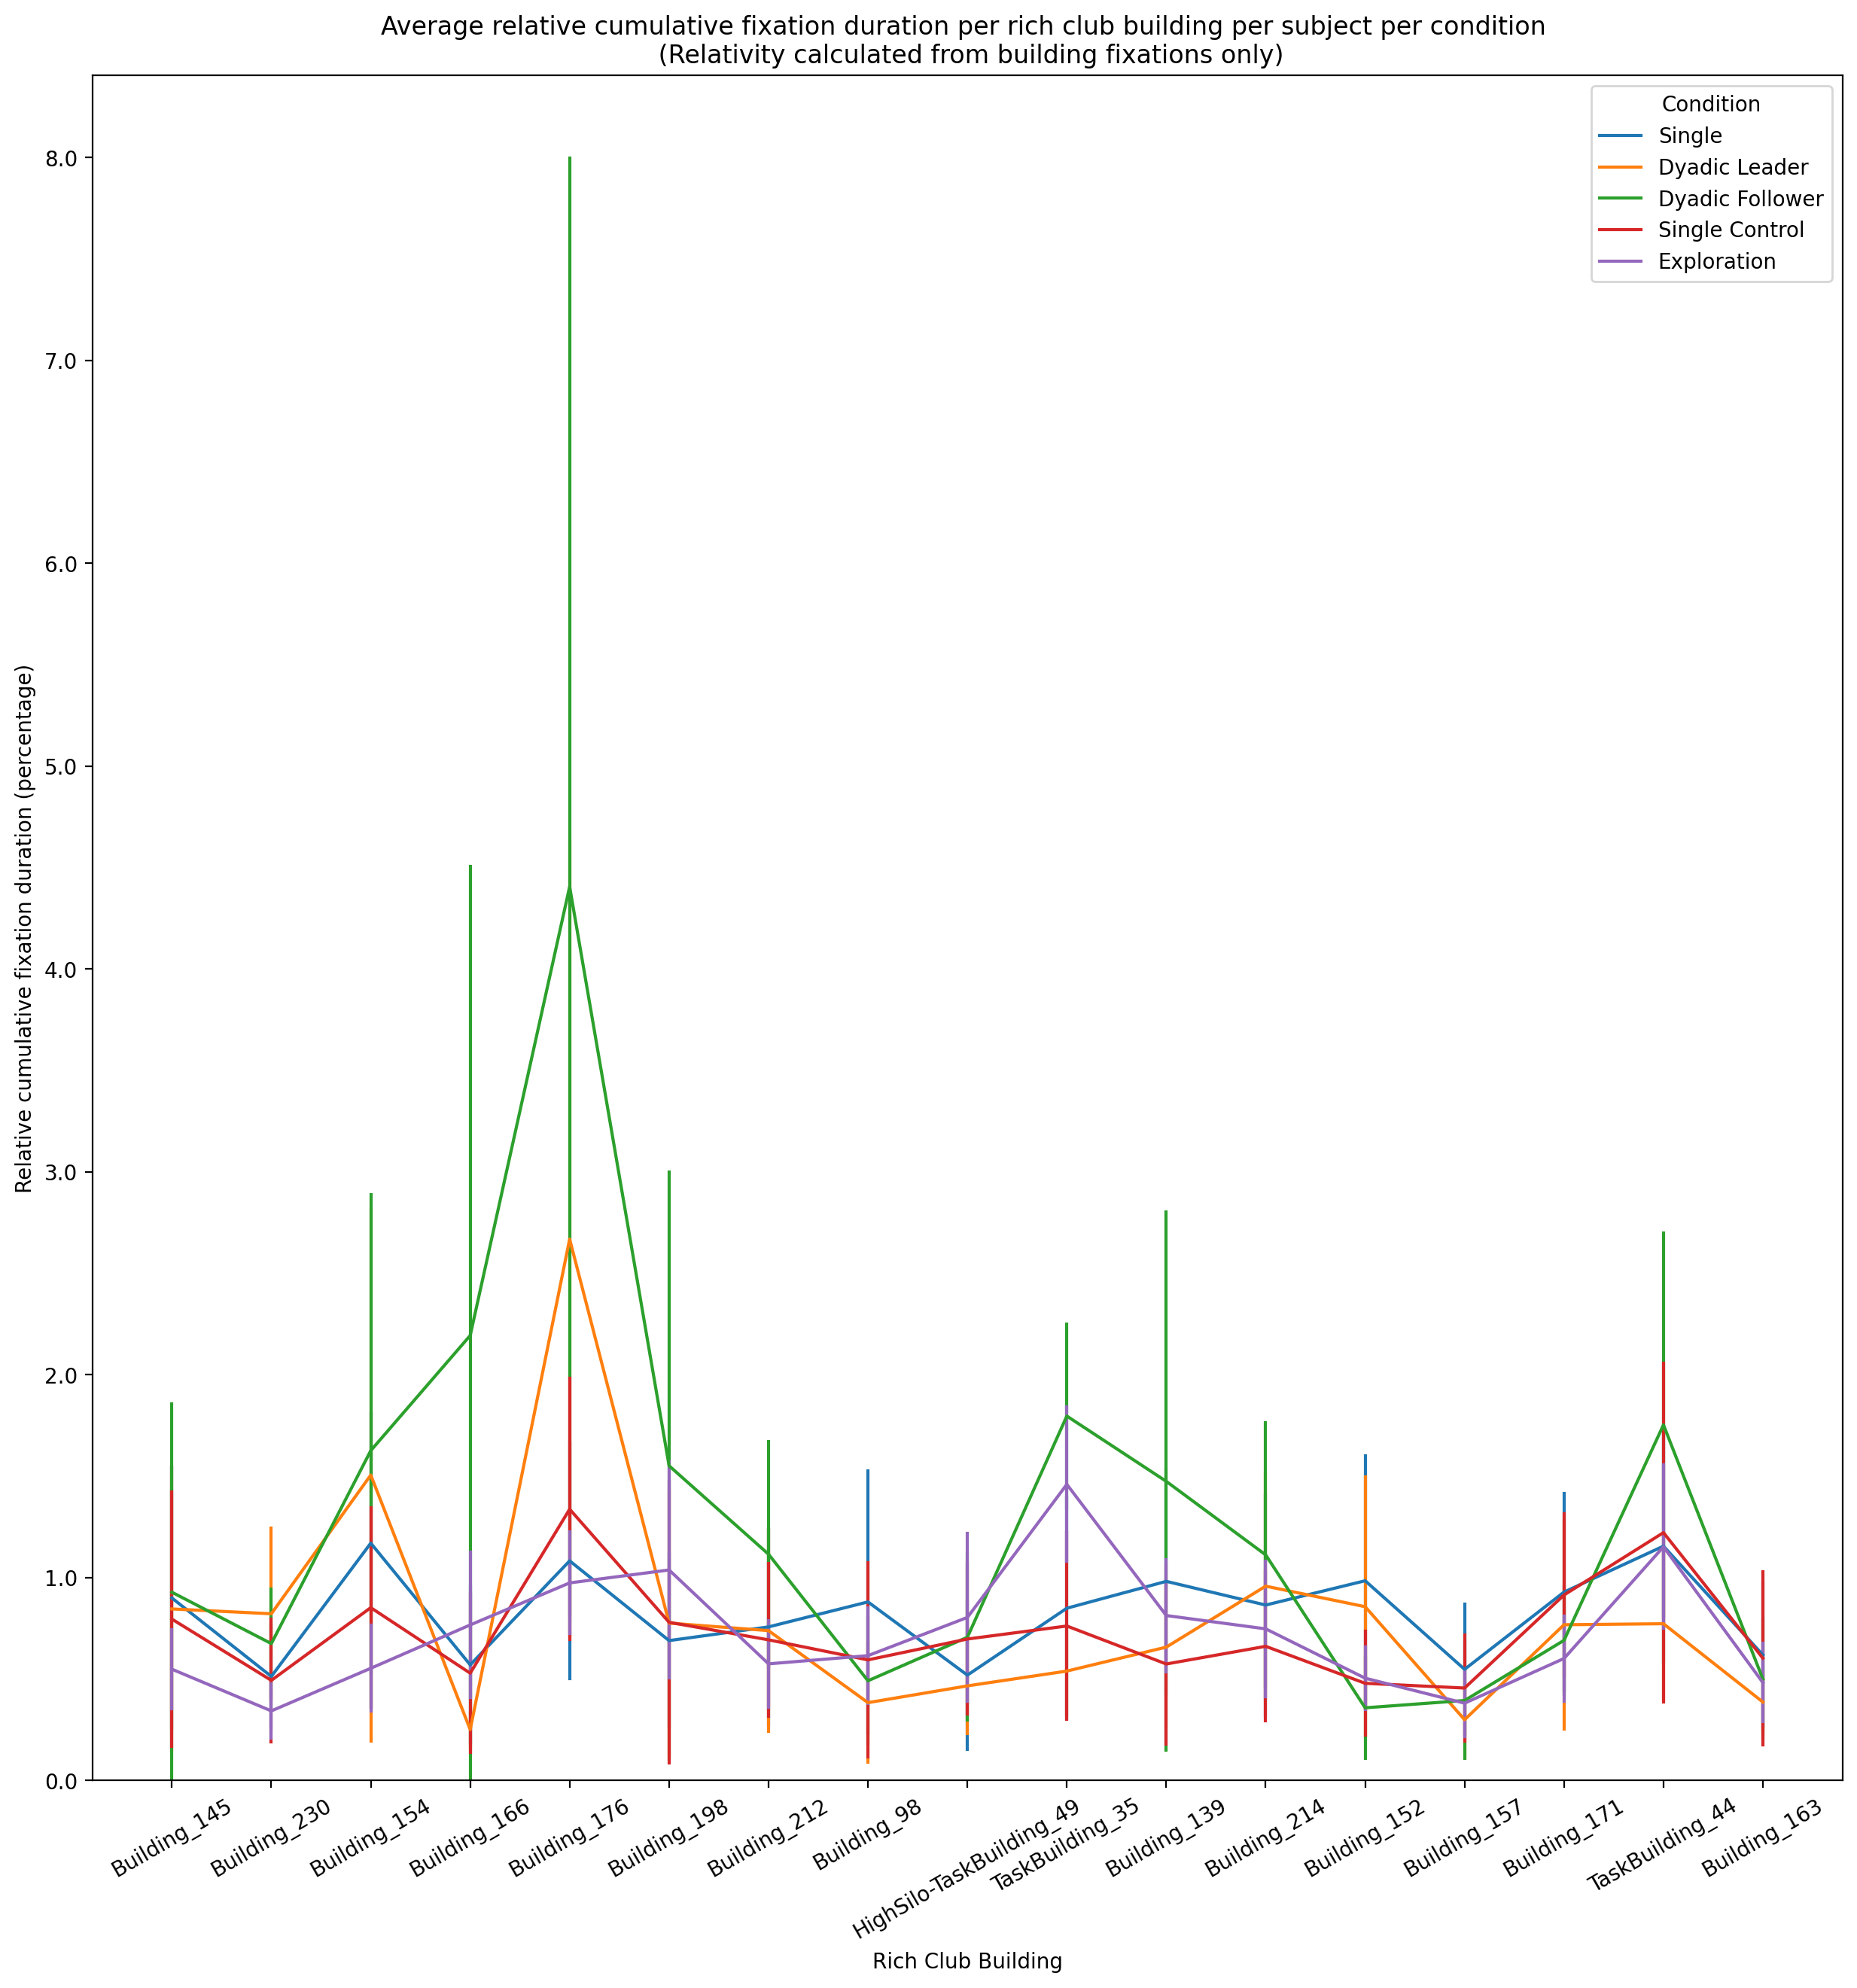

In [32]:
# All conditions, plot for rich club houses  

# Special treatment: 
# Combine entire available data.
# Only house hits.
# Plot relative hits per condition & subject on RichClub buildings.


data_df = rel_agg_df.copy(deep=True)

# Use rich club houses & filter data 
special_top_houses = list(rich_club_houses["House"])
data_df = data_df[data_df["ColliderName"].isin(special_top_houses)]

# plot 
fig, ax = plt.subplots(1,1, figsize=(15,15), squeeze = False, dpi=200)

g = sns.lineplot(data=data_df.groupby(["condition","subject_id","ColliderName"]).sum().reset_index(), x="ColliderName", y="rel_timediff_per_cond_subjectid_from_buildings", hue="condition", \
                 hue_order = ["single", "dyadic_leader", "dyadic_follower", "singlec", "exploration"], \
                 err_style = "bars", \
                 ci="sd", ax = ax[0,0])

plt.xticks(rotation = 30)
g.set_xlabel("Rich Club Building")

ax[0,0].title.set_text("Average relative cumulative fixation duration per rich club building per subject per condition \n (Relativity calculated from building fixations only)")

g.set(ylim= (0,None))

ylabels = [str(round(y * 100,2)) for y in g.get_yticks()]
g.set_yticklabels(ylabels)
g.set_ylabel("Relative cumulative fixation duration (percentage)")



legend = ax[0,0].get_legend()
legend_title = 'Condition'
legend_labels = ["Single", "Dyadic Leader", "Dyadic Follower", "Single Control", "Exploration"]
legend.set_title(legend_title)
for t, l in zip(legend.texts, legend_labels):
    t.set_text(l)


plt.savefig(SAVE_PATH + 'all_cond_rich_rel_from_buildings.png')
plt.show()





/Users/stefan/opt/anaconda3/envs/graphs/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator


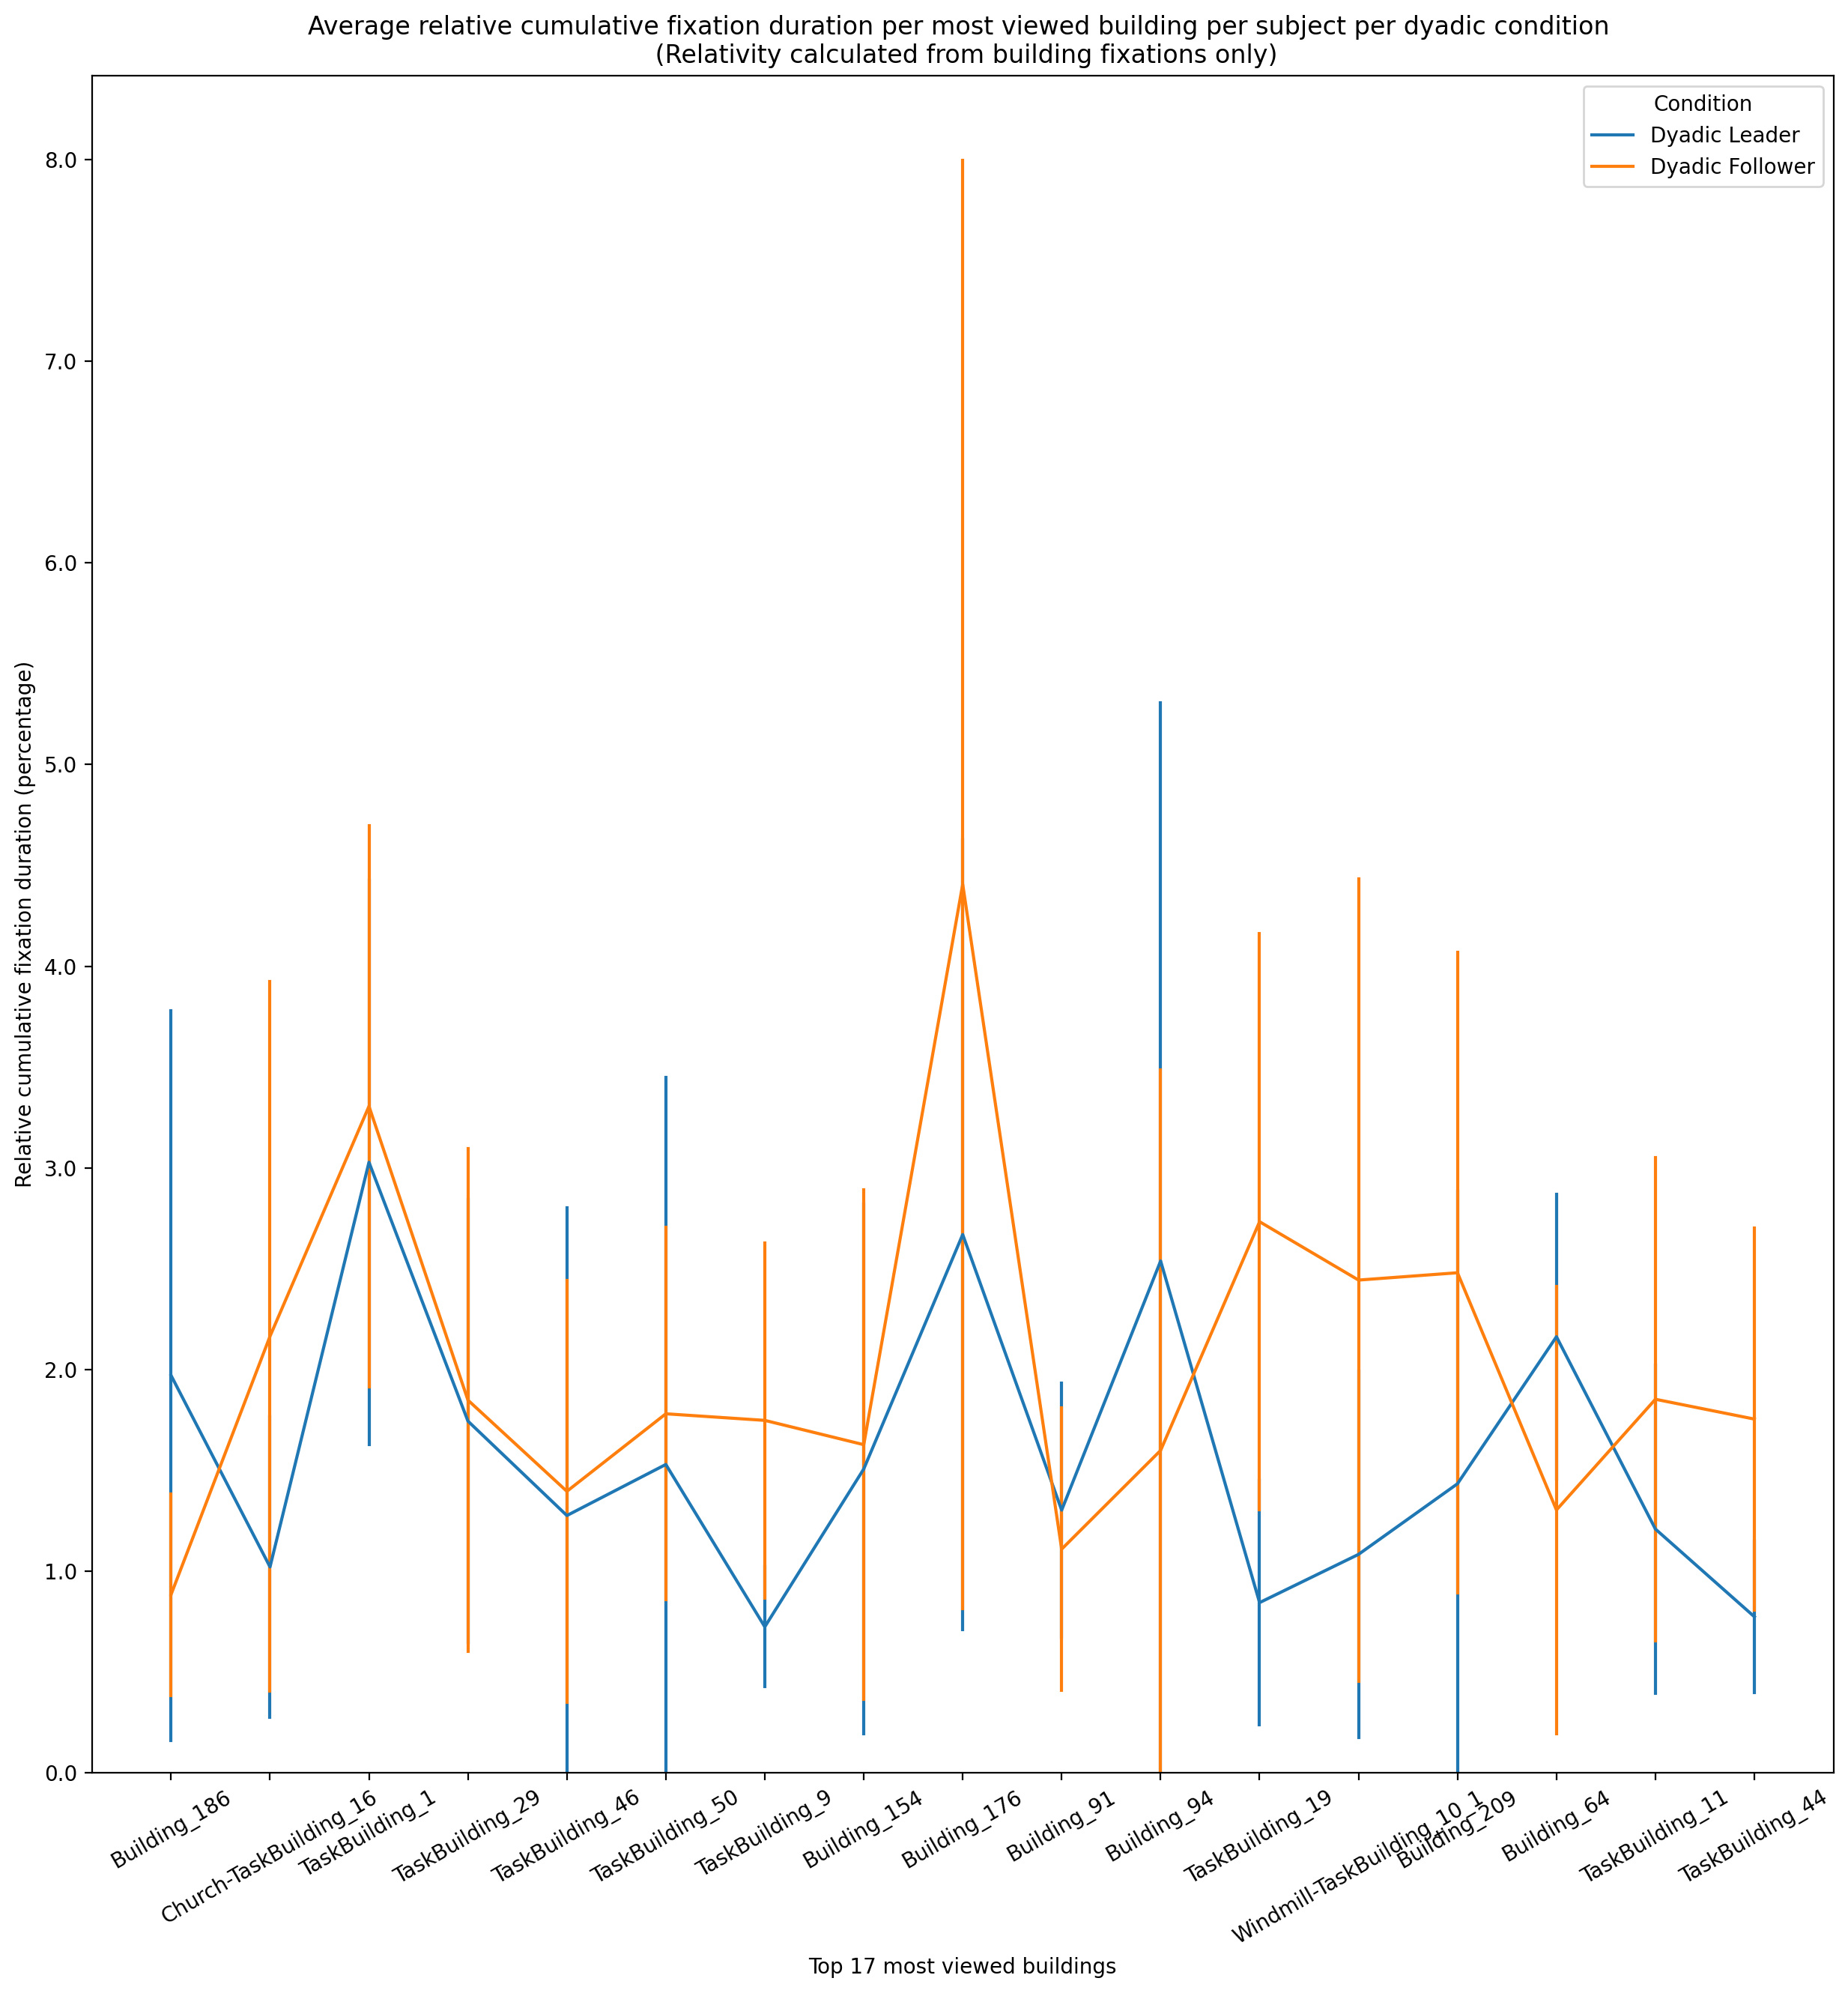

In [33]:
# Only Dyadic Leader and Dyadic Follower and SingleC, all paths, plot for most viewed houses   

# Special treatment: 
# Combine entire available data for Leader and Follower and SingleC.
# Exclude Avatar hits. 
# Plot relative hits per condition on most viewed buildings.


data_df = rel_agg_df.copy(deep=True)

# initial filter 
data_df = data_df[(data_df["condition"] == "dyadic_leader") | (data_df["condition"] == "dyadic_follower")]
    
# Use most viewed houses
special_top_houses = find_top_houses(data_df,17,False,"rel_other",rel_other_column="rel_samples_per_cond_from_buildings")
data_df = data_df[(data_df["ColliderName"].isin(special_top_houses))]

# plot 
fig, ax = plt.subplots(1,1, figsize=(15,15), squeeze = False, dpi=200)

g = sns.lineplot(data=data_df.groupby(["condition","subject_id","ColliderName"]).sum().reset_index(), x="ColliderName", y="rel_timediff_per_cond_subjectid_from_buildings", hue="condition", \
                 hue_order = ["dyadic_leader", "dyadic_follower"], \
                 err_style = "bars", \
                 ci="sd", ax = ax[0,0])

plt.xticks(rotation = 30)
g.set_xlabel("Top 17 most viewed buildings")

ax[0,0].title.set_text("Average relative cumulative fixation duration per most viewed building per subject per dyadic condition \n (Relativity calculated from building fixations only)")

g.set(ylim= (0,None))

ylabels = [str(round(y * 100,2)) for y in g.get_yticks()]
g.set_yticklabels(ylabels)
g.set_ylabel("Relative cumulative fixation duration (percentage)")



legend = ax[0,0].get_legend()
legend_title = 'Condition'
legend_labels = ["Dyadic Leader", "Dyadic Follower"]
legend.set_title(legend_title)
for t, l in zip(legend.texts, legend_labels):
    t.set_text(l)


plt.savefig(SAVE_PATH + 'dy_cond_most_viewed_rel_from_buildings.png')
    
plt.show()


/Users/stefan/opt/anaconda3/envs/graphs/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


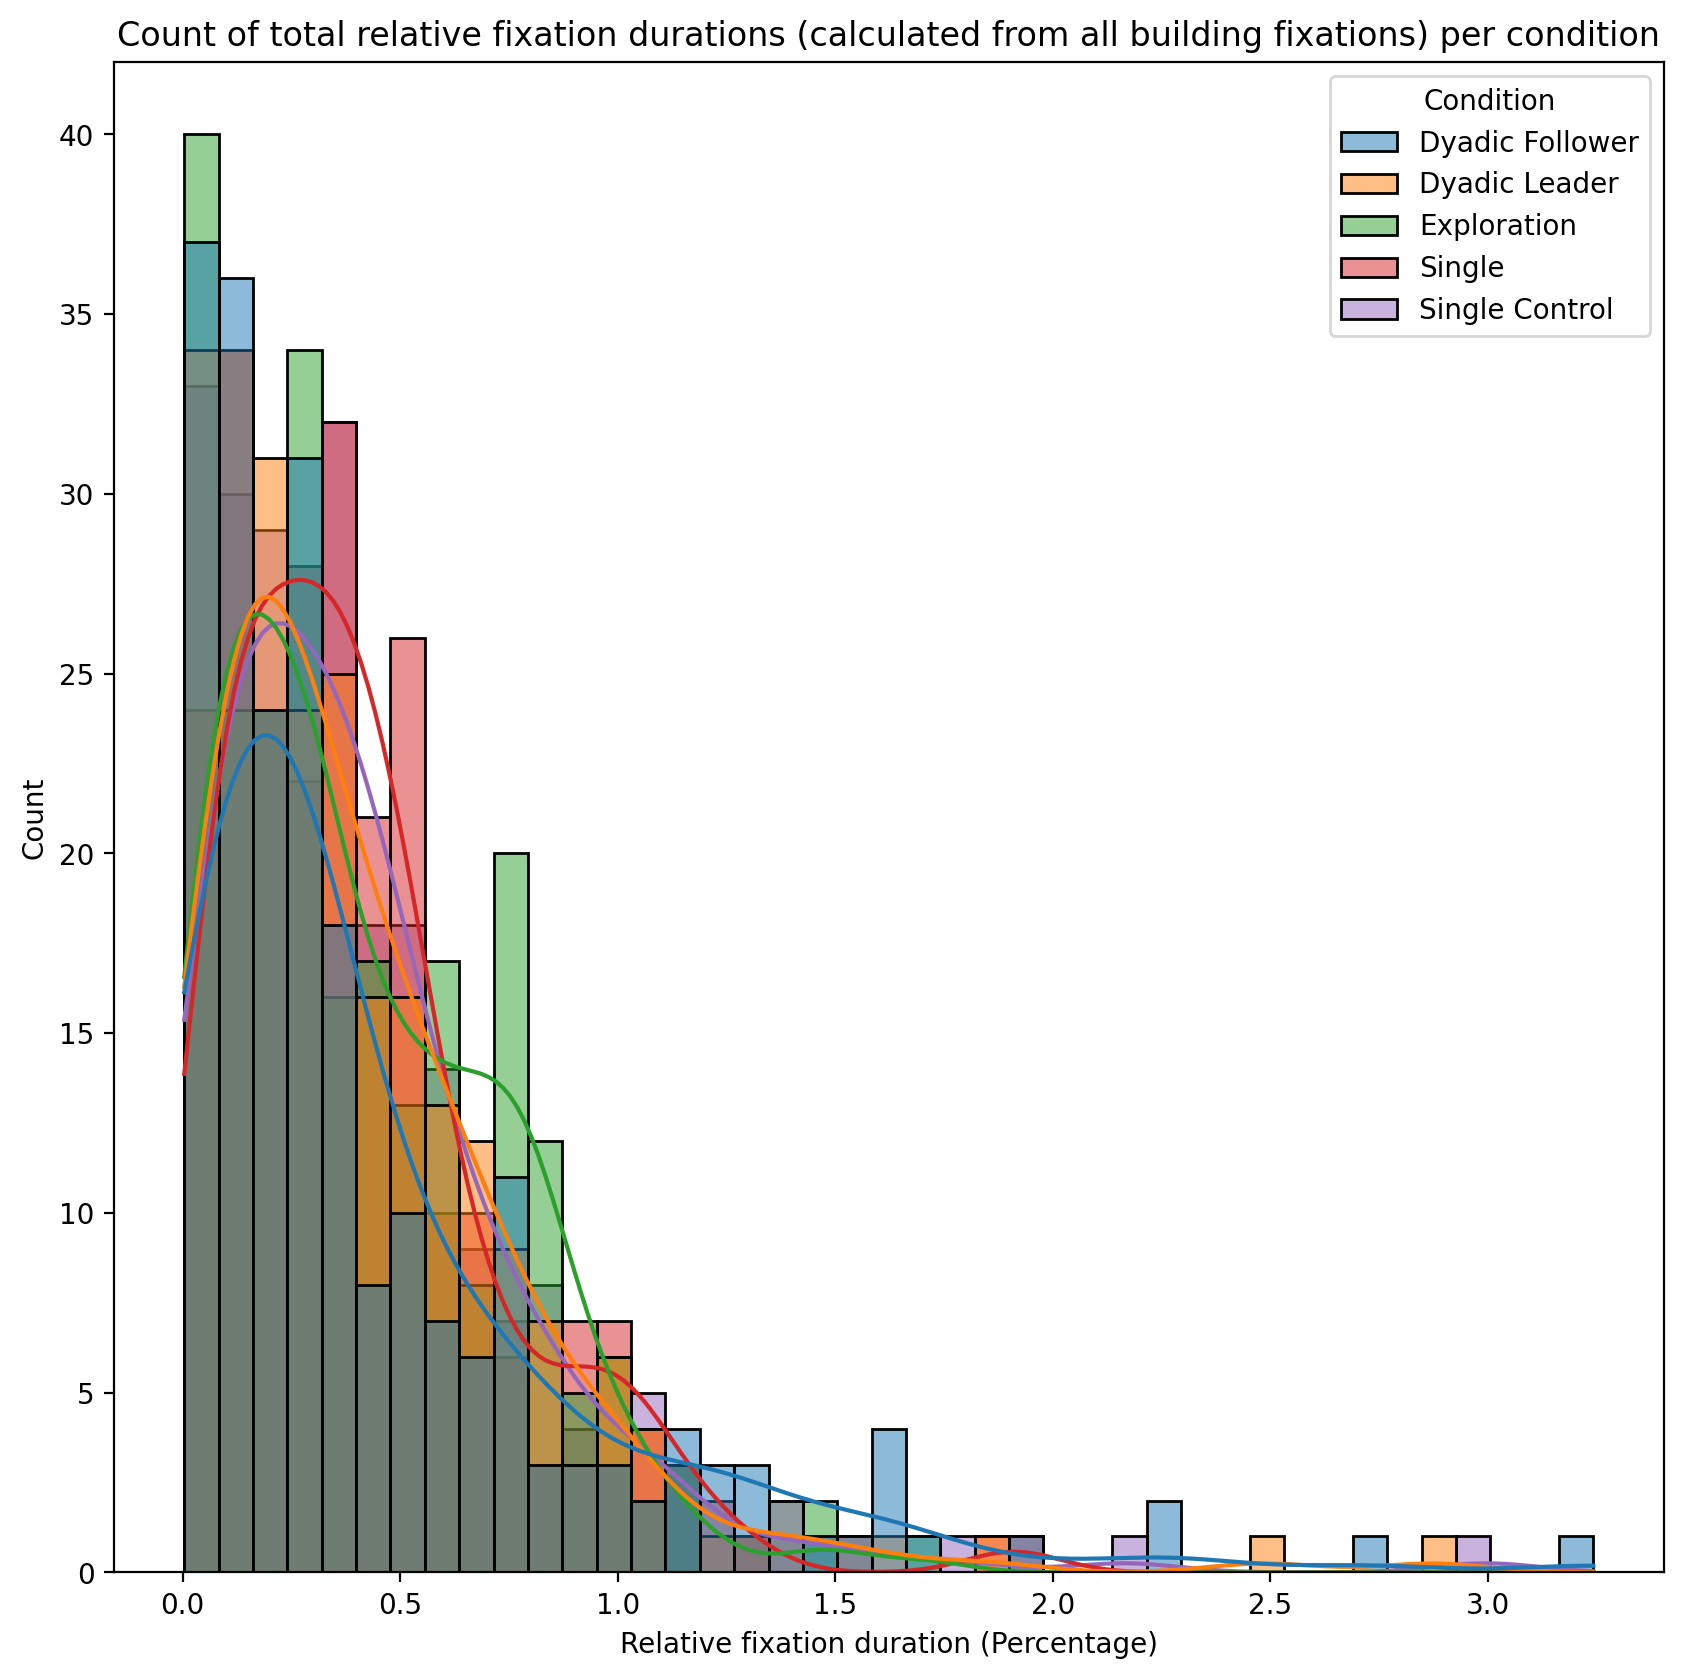

In [34]:
# Histogram: How many houses had which percentage of fixation-time? 

# Special treatment: 
# All data.
# Relative hits per condition (no avatar).

# (Since we use "no avatar" relative values here, the sum over all buildings (which is what data_df is) does not equal exactly one.
# But since we are only interested in buildings and not NoHit or Hand etc. this is fine for plotting purposes.)

# init
data_df = rel_agg_df.copy(deep=True)

# drop unnecessary data  
data_df = data_df.drop(columns=data_df.columns.difference(["condition","ColliderName","rel_timediff_per_cond_from_buildings"]))

# combine per collider per condition
data_df = data_df.groupby(["condition","ColliderName"]).sum().reset_index()

# plot 
fig, ax = plt.subplots(1,1,figsize=(10,10), squeeze = False, dpi=200)
g = sns.histplot(data=data_df, x = "rel_timediff_per_cond_from_buildings", hue = "condition", kde = True, ax = ax[0,0])

xlabels = [str(round(x * 100,2)) for x in g.get_xticks()]
g.set_xticklabels(xlabels)
g.set_xlabel("Relative fixation duration (Percentage)")

g.set_title("Count of total relative fixation durations (calculated from all building fixations) per condition")

legend = ax[0,0].get_legend()
legend_title = 'Condition'
legend_labels = ['Dyadic Follower', 'Dyadic Leader', 'Exploration', 'Single', 'Single Control']
legend.set_title(legend_title)
for t, l in zip(legend.texts, legend_labels):
    t.set_text(l)

plt.savefig(SAVE_PATH + 'rel_fix_count_all_cond.png')
plt.show()




/Users/stefan/opt/anaconda3/envs/graphs/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


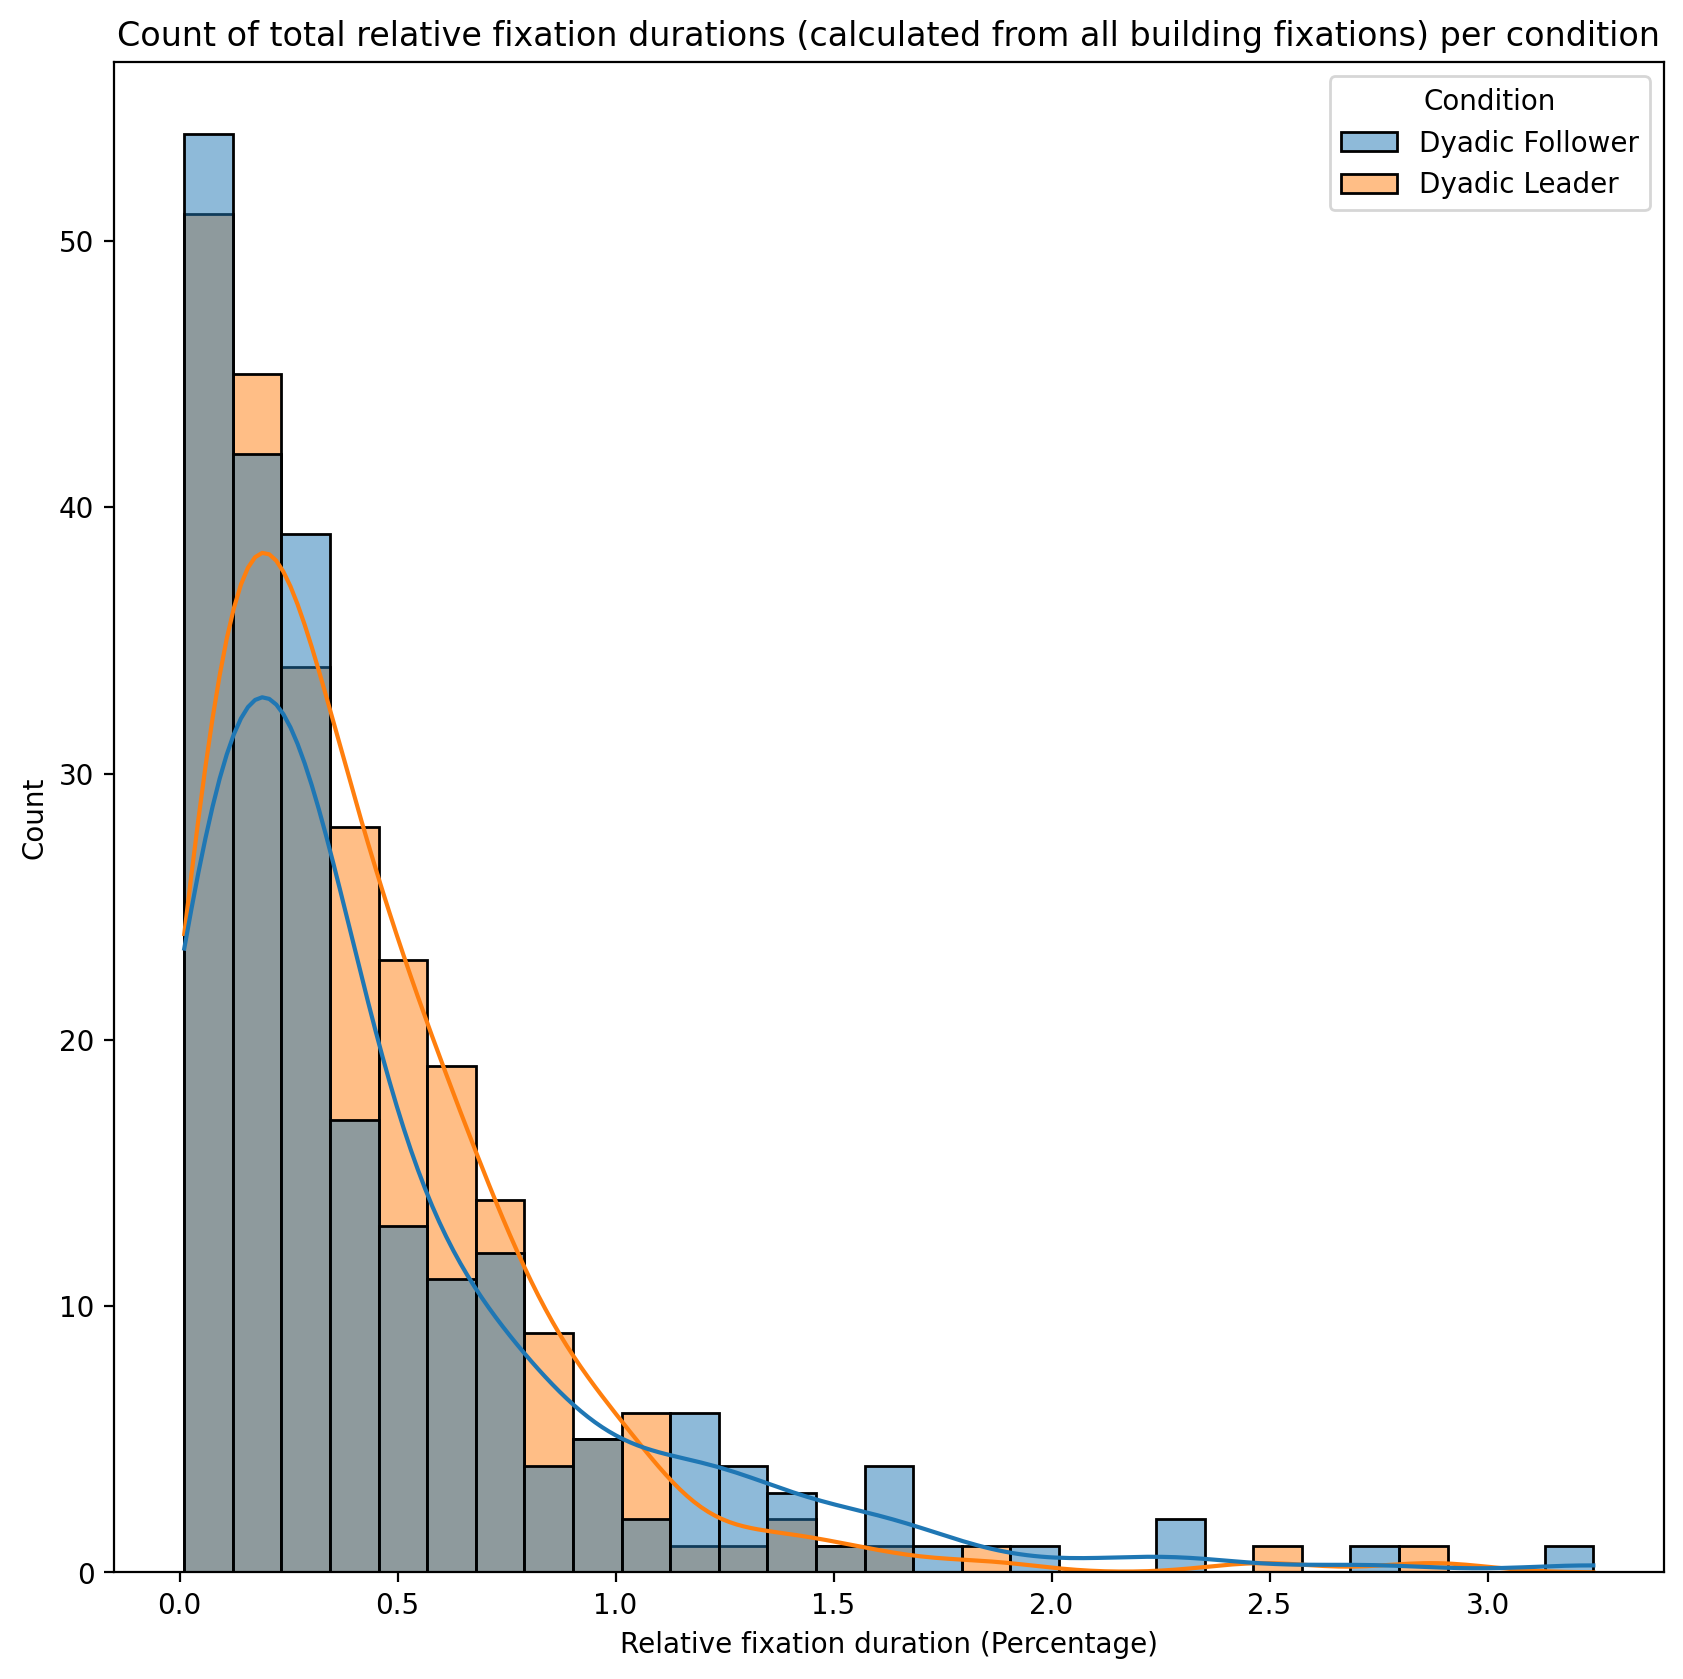

In [35]:
# Histogram: How many houses had which percentage of fixation-time? 

# Special treatment: 
# Only Dyadic Leader and Dyadic Follower 
# Combine entire available data for Leader and Follower
# Relative hits per condition (no avatar).

# (Since we use "no avatar" relative values here, the sum over all buildings (which is what data_df is) does not equal exactly one.
# But since we are only interested in buildings and not NoHit or Hand etc. this is fine for plotting purposes.)

# init 
data_df = rel_agg_df.copy(deep=True)

# initial filter 
data_df = data_df[(data_df["condition"] == "dyadic_leader") | (data_df["condition"] == "dyadic_follower")]

# drop unnecessary data  
data_df = data_df.drop(columns=data_df.columns.difference(["condition","ColliderName","rel_timediff_per_cond_from_buildings"]))

# combine per collider per condition
data_df = data_df.groupby(["condition","ColliderName"]).sum().reset_index()

# plot 
fig, ax = plt.subplots(1,1,figsize=(10,10), squeeze = False, dpi=200)
g = sns.histplot(data=data_df,x = "rel_timediff_per_cond_from_buildings", hue = "condition", kde = True, ax = ax[0,0])

xlabels = [str(round(x * 100,2)) for x in g.get_xticks()]
g.set_xticklabels(xlabels)
g.set_xlabel("Relative fixation duration (Percentage)")

g.set_title("Count of total relative fixation durations (calculated from all building fixations) per condition")

legend = ax[0,0].get_legend()
legend_title = 'Condition'
legend_labels = ['Dyadic Follower', 'Dyadic Leader']
legend.set_title(legend_title)
for t, l in zip(legend.texts, legend_labels):
    t.set_text(l)

plt.savefig(SAVE_PATH + 'rel_fix_count_dy_cond.png')
plt.show()



In [17]:
# Plot total fixation times per condition (per subject)
# Plot total rel. fixation times per condition on Phone, Hand, Avatar, NoHouse, Rich Club Buildings, Normal Buildings (per subject)

local_full_df = full_agg_df.copy(deep=True)

# Replace Rich Club Building Names by description
local_full_df.loc[local_full_df["ColliderName"].isin(list(rich_club_houses["House"])), "ColliderName"] = "Rich_Club_Building"

# Find non-rich club buildings 
non_rich_club_buildings = list(local_full_df.ColliderName.unique())
for coll in ["Avatar","Hand","NoHouse","NoHit","Phone","Rich_Club_Building"]:
    non_rich_club_buildings.remove(coll)
    
# Replace non-rich club building names by description 
local_full_df.loc[local_full_df["ColliderName"].isin(non_rich_club_buildings), "ColliderName"] = "Non_Rich_Club_Building"

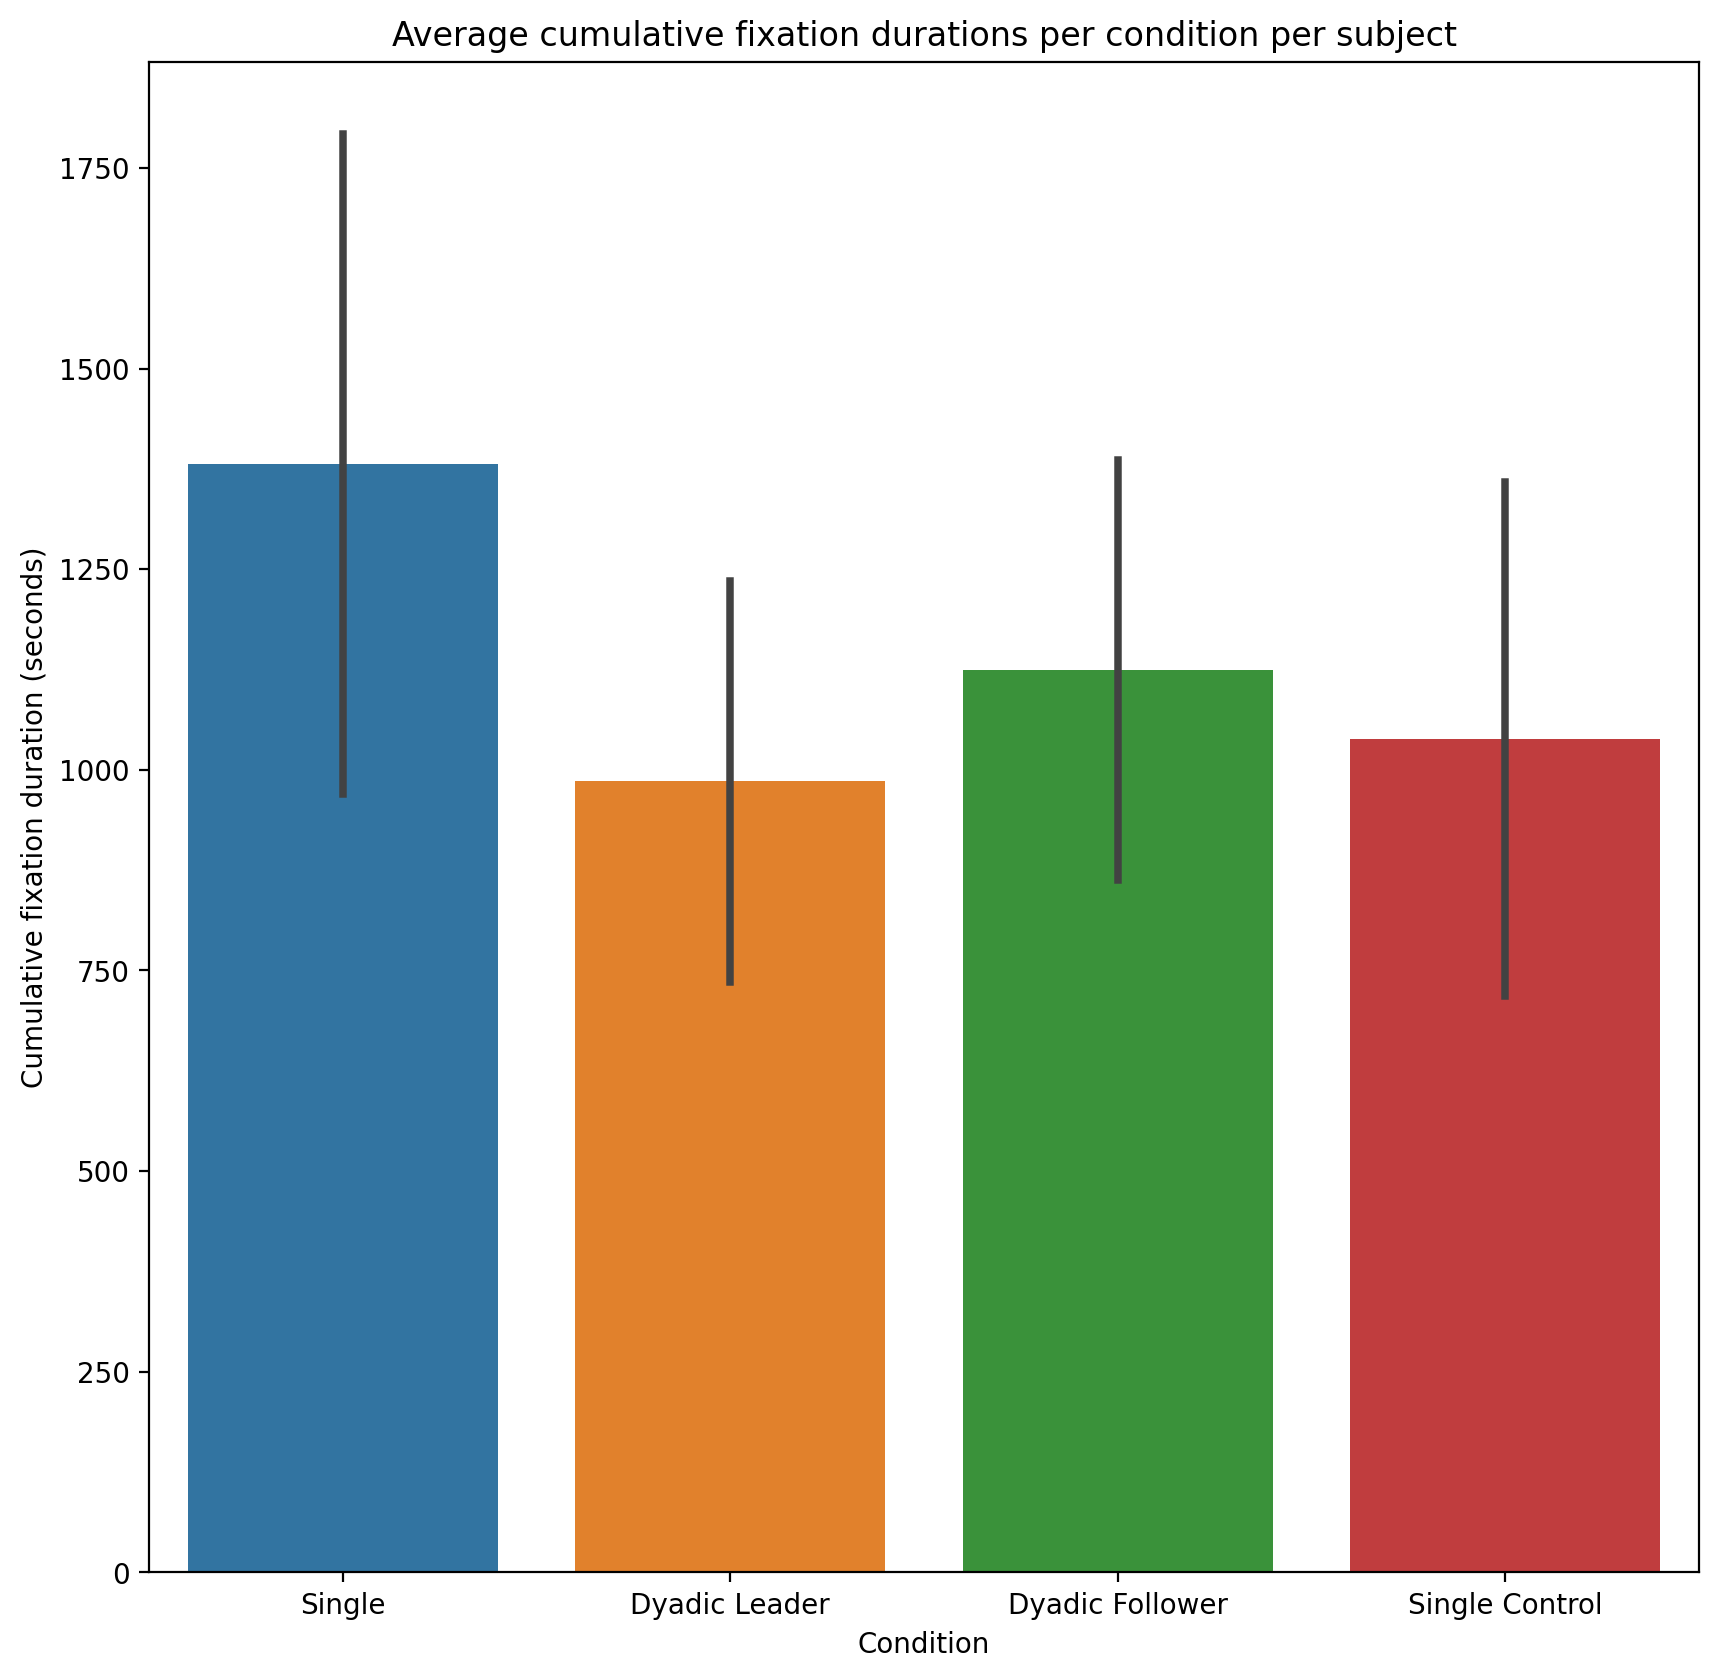


Totals (per subject): 
condition
dyadic_follower    1124.258364
dyadic_leader       985.494473
exploration        6855.785714
single             1381.071250
singlec            1038.750874
Name: timeDiff, dtype: float64
Totals (overall): 
condition
dyadic_follower      8994.066916
dyadic_leader        7883.955786
exploration        178250.428565
single              35907.852509
singlec             10387.508744
Name: timeDiff, dtype: float64


In [36]:
# plot, exclude Exploration
fig, ax = plt.subplots(1,1,figsize=(10,10), squeeze = False, dpi=200)
g = sns.barplot(data=local_full_df.groupby(["condition","subject_id"]).sum().reset_index(), x = "condition", y = "timeDiff", order = ["single","dyadic_leader","dyadic_follower","singlec"], ci="sd", ax = ax[0,0])



xlabels = ["Single","Dyadic Leader","Dyadic Follower","Single Control"]
g.set_xticklabels(xlabels)
g.set_xlabel("Condition")

g.set_ylabel("Cumulative fixation duration (seconds)")

g.set_title("Average cumulative fixation durations per condition per subject")

plt.savefig(SAVE_PATH + 'sum_fix_per_cond.png')
plt.show()

# Calculate corresponding values 
print()
print("Totals (per subject): ")
print(local_full_df.groupby(["condition","subject_id"]).sum().reset_index().groupby("condition").mean()["timeDiff"])
print("Totals (overall): ")
print(local_full_df.groupby("condition").sum()["timeDiff"])


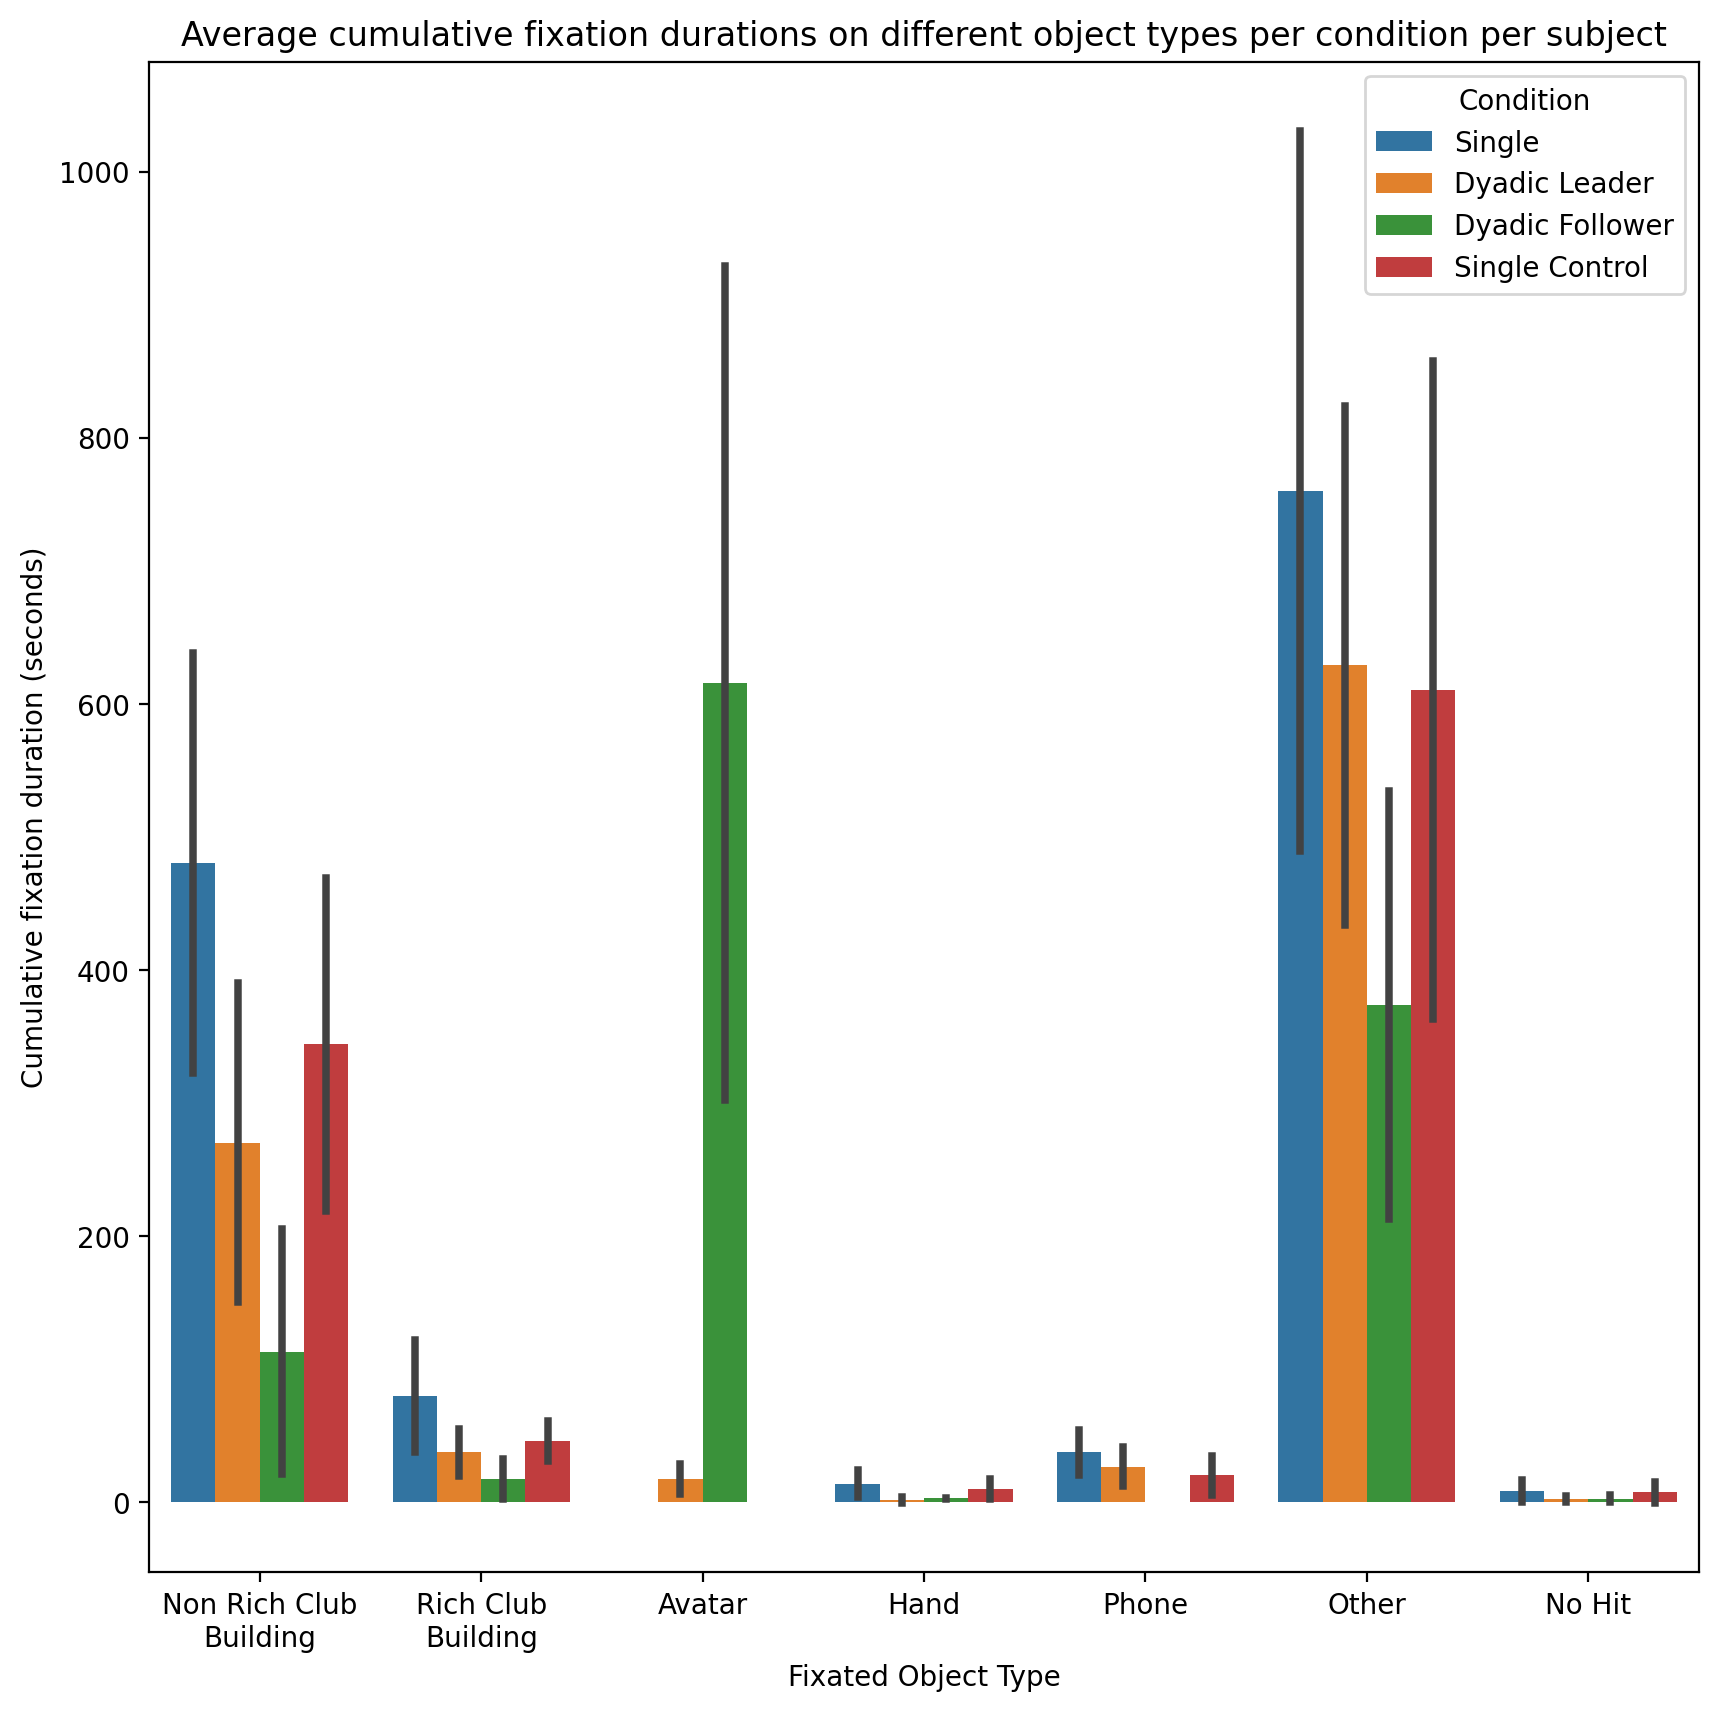

In [37]:
# plot, exclude Exploration 
fig, ax = plt.subplots(1,1,figsize=(10,10), squeeze = False, dpi=200)
g = sns.barplot(data=local_full_df.groupby(["condition","ColliderName","subject_id"]).sum().reset_index(), x = "ColliderName", y = "timeDiff", hue = "condition", \
                order = ["Non_Rich_Club_Building","Rich_Club_Building","Avatar","Hand","Phone","NoHouse","NoHit"], \
                hue_order = ["single","dyadic_leader","dyadic_follower","singlec"], \
                ci="sd", ax = ax[0,0])

xlabels = ["Non Rich Club\nBuilding","Rich Club\nBuilding","Avatar","Hand","Phone","Other","No Hit"]
g.set_xticklabels(xlabels)
g.set_xlabel("Fixated Object Type")

g.set_ylabel("Cumulative fixation duration (seconds)")

g.set_title("Average cumulative fixation durations on different object types per condition per subject")

legend = ax[0,0].get_legend()
legend_title = 'Condition'
legend_labels = ['Single','Dyadic Leader', 'Dyadic Follower', 'Single Control']
legend.set_title(legend_title)
for t, l in zip(legend.texts, legend_labels):
    t.set_text(l)

plt.savefig(SAVE_PATH + 'sum_fix_per_cond_per_collider.png')
plt.show()


# Old Analysis

### Using Overall Top House List

### Single condition, single startpoint, multiple paths, multiple subjects

In [ ]:
select_condition = "Single"
select_start_point = "A"

data_df = rel_agg_df.copy(deep=True)
data_df = data_df[(data_df["condition"] == select_condition.lower()) & (data_df["start_point"] == select_start_point)]
data_df = data_df[(data_df["ColliderName"].isin(top_house_names))]


# create order
collider_name_list = top_house_names.copy()
collider_name_list.sort()

# plot 
fig, ax = plt.subplots(1,1,figsize=(20,20), squeeze = False) 
g = sns.pointplot(data=data_df, x="ColliderName", y="Samples", hue="unique_path_name", ci="sd", order=collider_name_list, ax = ax[0,0])
g.set_xticklabels(g.get_xticklabels(), rotation=30)
ax[0,0].title.set_text("Condition: " + select_condition + " - Starting Point: " + select_start_point + " - Absolute Samples - Top house labels selected over all conditions")


fig.tight_layout()
plt.show()

In [ ]:
select_condition = "Single"
select_start_point = "A"

data_df = rel_agg_df.copy(deep=True)
data_df = data_df[(data_df["condition"] == select_condition.lower()) & (data_df["start_point"] == select_start_point)]
data_df = data_df[(data_df["ColliderName"].isin(top_house_names))]

# create order
collider_name_list = top_house_names.copy()
collider_name_list.sort()

# plot 
fig, ax = plt.subplots(1,1,figsize=(20,20), squeeze = False)
g = sns.pointplot(data=data_df, x="ColliderName", y="rel_samples_per_path_from_all", hue="unique_path_name", ci="sd", order=collider_name_list, ax = ax[0,0])
g.set_xticklabels(g.get_xticklabels(), rotation=30)
ax[0,0].title.set_text("Condition: " + select_condition + " - Starting Point: " + select_start_point + " - Relative (from all hits) Samples - Top house labels selected over all conditions")


fig.tight_layout()
plt.show()

In [ ]:
select_condition = "Single"
select_start_point = "A"

data_df = rel_agg_df.copy(deep=True)
data_df = data_df[(data_df["condition"] == select_condition.lower()) & (data_df["start_point"] == select_start_point)]
data_df = data_df[(data_df["ColliderName"].isin(top_house_names))]


# create order
collider_name_list = top_house_names.copy()
collider_name_list.sort()

# plot 
fig, ax = plt.subplots(1,1,figsize=(20,20), squeeze = False)
g = sns.pointplot(data=data_df, x="ColliderName", y="rel_samples_per_path_from_buildings", hue="unique_path_name", ci="sd", order=collider_name_list, ax = ax[0,0])
g.set_xticklabels(g.get_xticklabels(), rotation=30)
ax[0,0].title.set_text("Condition: " + select_condition + " - Starting Point: " + select_start_point + " - Relative (from buildings) Samples - Top house labels selected over all conditions")


fig.tight_layout()
plt.show()

### Single condition, single startpoint, multiple paths, multiple subjects

In [ ]:
include_exploration = False

data_df = rel_agg_df.copy(deep=True)

# Create a sorted collider names list, with top houses in the beginning
# Use for categorical data in the dataframe for nice plotting 
collider_name_list = top_house_names.copy()
collider_name_list.sort()
for collider in data_df["ColliderName"]:
    if collider not in collider_name_list:
        collider_name_list.append(collider)
data_df["ColliderName"] = pd.Categorical(data_df["ColliderName"],
                                   categories=collider_name_list,
                                   ordered=True)

# filter  
data_df = data_df[(data_df["ColliderName"].isin(top_house_names))]
if not include_exploration:
    data_df = data_df[data_df["condition"] != "exploration"]
    

# plot 
fig, ax = plt.subplots(1,1,figsize=(20,20), squeeze = False)

# Single" 
g = sns.lineplot(data=data_df, x="ColliderName", y="Samples", hue="condition", style="start_point", err_style="bars", ci="sd", ax = ax[0,0])
plt.xticks(rotation = 30)
ax[0,0].title.set_text("Most viewed buildings per condition and start point - Multiple subjects - Multiple paths - Absolute Samples")


fig.tight_layout()
plt.show()



In [ ]:
include_exploration = False

data_df = rel_agg_df.copy(deep=True)

# Create a sorted collider names list, with top houses in the beginning
# Use for categorical data in the dataframe for nice plotting 
collider_name_list = top_house_names.copy()
collider_name_list.sort()
for collider in data_df["ColliderName"]:
    if collider not in collider_name_list:
        collider_name_list.append(collider)
data_df["ColliderName"] = pd.Categorical(data_df["ColliderName"],
                                   categories=collider_name_list,
                                   ordered=True)

# filter 
data_df = data_df[(data_df["ColliderName"].isin(top_house_names))]
if not include_exploration:
    data_df = data_df[data_df["condition"] != "exploration"]
    

# plot 
fig, ax = plt.subplots(1,1,figsize=(20,20), squeeze = False)

# Single" 
g = sns.lineplot(data=data_df, x="ColliderName", y="rel_samples_per_path_from_all", hue="condition", style="start_point", err_style="bars", ci="sd", ax = ax[0,0])
plt.xticks(rotation = 30)
ax[0,0].title.set_text("Most viewed buildings per condition and start point - Multiple subjects - Multiple paths - Relative Samples")


fig.tight_layout()
plt.show()



### Using Custom House Lists

In [ ]:
# Only Single

data_df = rel_agg_df.copy(deep=True)

# Initial filter 
data_df = data_df[data_df["condition"] == "single"]

# Find top houses
special_top_houses = find_top_houses(data_df,30,False,"rel_from_all_overall")


# Create a sorted collider names list, with top houses in the beginning
# Use for categorical data in the dataframe for nice plotting 
collider_name_list = special_top_houses.copy()
collider_name_list.sort()
for collider in data_df["ColliderName"]:
    if collider not in collider_name_list:
        collider_name_list.append(collider)
data_df["ColliderName"] = pd.Categorical(data_df["ColliderName"],
                                   categories=collider_name_list,
                                   ordered=True)

# Later filter
data_df = data_df[(data_df["ColliderName"].isin(special_top_houses))]
    

# plot 
fig, ax = plt.subplots(1,1,figsize=(20,20), squeeze = False)

# Single" 
g = sns.lineplot(data=data_df, x="ColliderName", y="rel_samples_per_path_from_all", hue="start_point", err_style="bars", ci="sd", ax = ax[0,0])
plt.xticks(rotation = 30)
ax[0,0].title.set_text("Most viewed buildings in 'Single' condition and per start point - Multiple subjects - Multiple paths - Relative Samples")


fig.tight_layout()
plt.show()

In [ ]:
# Only SingleC

data_df = rel_agg_df.copy(deep=True)

# initial filter
data_df = data_df[data_df["condition"] == "singlec"]

# Find top houses
special_top_houses = find_top_houses(data_df,30,False,"rel_from_all_overall")

# Create a sorted collider names list, with top houses in the beginning
# Use for categorical data in the dataframe for nice plotting 
collider_name_list = special_top_houses.copy()
collider_name_list.sort()
for collider in data_df["ColliderName"]:
    if collider not in collider_name_list:
        collider_name_list.append(collider)
data_df["ColliderName"] = pd.Categorical(data_df["ColliderName"],
                                   categories=collider_name_list,
                                   ordered=True)

# later filter 
data_df = data_df[(data_df["ColliderName"].isin(special_top_houses))]

# plot 
fig, ax = plt.subplots(1,1,figsize=(20,20), squeeze = False)

# Single" 
g = sns.lineplot(data=data_df, x="ColliderName", y="rel_samples_per_path_from_all", hue="start_point", err_style="bars", ci="sd", ax = ax[0,0])
plt.xticks(rotation = 30)
ax[0,0].title.set_text("Most viewed buildings in 'SingleC' condition and per start point - Multiple subjects - Multiple paths - Relative Samples")


fig.tight_layout()
plt.show()

In [ ]:
# Only Dyadic Follower 

data_df = rel_agg_df.copy(deep=True)

# initial filter 
data_df = data_df[data_df["condition"] == "dyadic_follower"]

# Find top houses
special_top_houses = find_top_houses(data_df,30,False,"rel_from_all_overall")

# Create a sorted collider names list, with top houses in the beginning
# Use for categorical data in the dataframe for nice plotting 
collider_name_list = special_top_houses.copy()
collider_name_list.sort()
for collider in data_df["ColliderName"]:
    if collider not in collider_name_list:
        collider_name_list.append(collider)
data_df["ColliderName"] = pd.Categorical(data_df["ColliderName"],
                                   categories=collider_name_list,
                                    ordered=True)

data_df = data_df[(data_df["ColliderName"].isin(special_top_houses))]

# plot 
fig, ax = plt.subplots(1,1,figsize=(20,20), squeeze = False)

# Single" 
g = sns.lineplot(data=data_df, x="ColliderName", y="rel_samples_per_path_from_all", hue="start_point", err_style="bars", ci="sd", ax = ax[0,0])
plt.xticks(rotation = 30)
ax[0,0].title.set_text("Most viewed buildings in 'Dyadic Follower' condition and per start point - Multiple subjects - Multiple paths - Relative Samples")


fig.tight_layout()
plt.show()

In [ ]:
# Only Dyadic Leader 

data_df = rel_agg_df.copy(deep=True)

# initial filter 
data_df = data_df[data_df["condition"] == "dyadic_leader"]

# Find top houses
special_top_houses = find_top_houses(data_df,30,False,"rel_from_all_overall")

# Create a sorted collider names list, with top houses in the beginning
# Use for categorical data in the dataframe for nice plotting 
collider_name_list = special_top_houses.copy()
collider_name_list.sort()
for collider in data_df["ColliderName"]:
    if collider not in collider_name_list:
        collider_name_list.append(collider)
data_df["ColliderName"] = pd.Categorical(data_df["ColliderName"],
                                   categories=collider_name_list,
                                   ordered=True)

# later filter
data_df = data_df[(data_df["ColliderName"].isin(special_top_houses))]

# plot 
fig, ax = plt.subplots(1,1,figsize=(20,20), squeeze = False)

# Single" 
g = sns.lineplot(data=data_df, x="ColliderName", y="rel_samples_per_path_from_all", hue="start_point", err_style="bars", ci="sd", ax = ax[0,0])
plt.xticks(rotation = 30)
ax[0,0].title.set_text("Most viewed buildings in 'Dyadic Leader' condition and per start point - Multiple subjects - Multiple paths - Relative Samples")


fig.tight_layout()
plt.show()

In [ ]:
# Only Dyadic Leader and Dyadic Follower

data_df = rel_agg_df.copy(deep=True)

# initial filter 
data_df = data_df[(data_df["condition"] == "dyadic_leader") | (data_df["condition"] == "dyadic_follower")]
    
# Find top houses
special_top_houses = find_top_houses(data_df,30,False,"rel_from_all_overall")

# Create a sorted collider names list, with top houses in the beginning
# Use for categorical data in the dataframe for nice plotting 
collider_name_list = special_top_houses.copy()
collider_name_list.sort()
for collider in data_df["ColliderName"]:
    if collider not in collider_name_list:
        collider_name_list.append(collider)
data_df["ColliderName"] = pd.Categorical(data_df["ColliderName"],
                                   categories=collider_name_list,
                                   ordered=True)

# later filter
data_df = data_df[(data_df["ColliderName"].isin(special_top_houses))]

# plot 
fig, ax = plt.subplots(1,1,figsize=(20,20), squeeze = False)

# Single" 
g = sns.lineplot(data=data_df, x="ColliderName", y="rel_samples_per_path_from_all", hue="condition", style="start_point", err_style="bars", ci="sd", ax = ax[0,0])
plt.xticks(rotation = 30)
ax[0,0].title.set_text("Most viewed buildings in 'Dyadic Leader' or 'Dyadic Follower' condition and per start point - Multiple subjects - Multiple paths - Relative Samples")


fig.tight_layout()
plt.show()

In [ ]:
# Only SingleC and Dyadic Leader

data_df = rel_agg_df.copy(deep=True)

# initial filter 
data_df = data_df[(data_df["condition"] == "singlec") | (data_df["condition"] == "dyadic_leader")]
    
# Find top houses
special_top_houses = find_top_houses(data_df,30,False,"rel_from_all_overall")

# Create a sorted collider names list, with top houses in the beginning
# Use for categorical data in the dataframe for nice plotting 
collider_name_list = special_top_houses.copy()
collider_name_list.sort()
for collider in data_df["ColliderName"]:
    if collider not in collider_name_list:
        collider_name_list.append(collider)
data_df["ColliderName"] = pd.Categorical(data_df["ColliderName"],
                                   categories=collider_name_list,
                                   ordered=True)
 
# later filter
data_df = data_df[(data_df["ColliderName"].isin(special_top_houses))]

# plot 
fig, ax = plt.subplots(1,1,figsize=(20,20), squeeze = False)

# Single" 
g = sns.lineplot(data=data_df, x="ColliderName", y="rel_samples_per_path_from_all", hue="condition", style="start_point", err_style="bars", ci="sd", ax = ax[0,0])
plt.xticks(rotation = 30)
ax[0,0].title.set_text("Most viewed buildings in 'SingleC' or 'Dyadic Leader' condition and per start point - Multiple subjects - Multiple paths - Relative Samples")


fig.tight_layout()
plt.show()

In [ ]:
# Only Single

data_df = rel_agg_df.copy(deep=True)

# Initial filter 
data_df = data_df[data_df["condition"] == "single"]

# Find top houses
special_top_houses = find_top_houses(data_df,30,False,"rel_from_all_overall")


# Create a sorted collider names list, with top houses in the beginning
# Use for categorical data in the dataframe for nice plotting 
collider_name_list = special_top_houses.copy()
collider_name_list.sort()
for collider in data_df["ColliderName"]:
    if collider not in collider_name_list:
        collider_name_list.append(collider)
data_df["ColliderName"] = pd.Categorical(data_df["ColliderName"],
                                   categories=collider_name_list,
                                   ordered=True)

# Later filter
data_df = data_df[(data_df["ColliderName"].isin(special_top_houses))]
    

# plot 
fig, ax = plt.subplots(1,1,figsize=(20,20), squeeze = False)

# Single" 
g = sns.lineplot(data=data_df, x="ColliderName", y="rel_samples_per_path_from_all", hue="unique_path_name", style="start_point", err_style="bars", ci="sd", ax = ax[0,0])
plt.xticks(rotation = 30)
ax[0,0].title.set_text("Most viewed buildings in 'Single' condition per path and per start point - Multiple subjects - Multiple paths - Relative Samples")


fig.tight_layout()
plt.show()

In [ ]:
# Only Single, only some paths 

data_df = rel_agg_df.copy(deep=True)

# Initial filter 
data_df = data_df[data_df["condition"] == "single"]
data_df = data_df[data_df["unique_path_name"].isin(["A_1_B_9","A_3_B_7","A_5_B_5","A_7_B_3","A_9_B_1"])]

# Find top houses
special_top_houses = find_top_houses(data_df,30,False,"rel_from_all_overall")


# Create a sorted collider names list, with top houses in the beginning
# Use for categorical data in the dataframe for nice plotting 
collider_name_list = special_top_houses.copy()
collider_name_list.sort()
for collider in data_df["ColliderName"]:
    if collider not in collider_name_list:
        collider_name_list.append(collider)
data_df["ColliderName"] = pd.Categorical(data_df["ColliderName"],
                                   categories=collider_name_list,
                                   ordered=True)

# Later filter
data_df = data_df[(data_df["ColliderName"].isin(special_top_houses))]
    

# plot 
fig, ax = plt.subplots(1,1,figsize=(20,20), squeeze = False)

# Single" 
g = sns.lineplot(data=data_df, x="ColliderName", y="rel_samples_per_path_from_all", hue="unique_path_name", style="start_point", err_style="bars", ci="sd", ax = ax[0,0])
plt.xticks(rotation = 30)
ax[0,0].title.set_text("Most viewed buildings in 'Single' condition per path and per start point - Multiple subjects - Multiple paths - Relative Samples")


fig.tight_layout()
plt.show()

In [ ]:
# Only SingleC and Dyadic Leader, only one path (A_6_B_4)

# use rel from buildings here

data_df = rel_agg_df.copy(deep=True)

# initial filter 
data_df = data_df[(data_df["condition"] == "singlec") | (data_df["condition"] == "dyadic_leader")]
data_df = data_df[data_df["unique_path_name"].isin(["A_6_B_4"])]

    
# Find top houses
special_top_houses = find_top_houses(data_df,30,False,"rel_from_buildings_overall")

# Create a sorted collider names list, with top houses in the beginning
# Use for categorical data in the dataframe for nice plotting 
collider_name_list = special_top_houses.copy()
collider_name_list.sort()
for collider in data_df["ColliderName"]:
    if collider not in collider_name_list:
        collider_name_list.append(collider)
data_df["ColliderName"] = pd.Categorical(data_df["ColliderName"],
                                   categories=collider_name_list,
                                   ordered=True)
 
# later filter
data_df = data_df[(data_df["ColliderName"].isin(special_top_houses))]

# plot 
fig, ax = plt.subplots(1,1,figsize=(20,20), squeeze = False)

# Single" 
g = sns.lineplot(data=data_df, x="ColliderName", y="rel_samples_per_path_from_buildings", hue="condition", style="start_point", err_style="bars", ci="sd", ax = ax[0,0])
plt.xticks(rotation = 30)
ax[0,0].title.set_text("Most viewed buildings in 'SingleC' or 'Dyadic Leader' condition and per start point - Multiple subjects - One path (A_6_B_4) - Relative Samples from Buildings")


fig.tight_layout()
plt.show()

## Investigating Follower vs Leader (vs SingleC)
Use relative hits that take into account all hits excluding Avatar hits.

In [ ]:
# Relative samples verification
# Two paths, 8 leaders, 8 followers -> 2*(8+8) = 32 relative sample sum 

desired_path_test = ["A_6_B_4","A_7_B_3"]
data_df_test = rel_agg_df.copy(deep=True)
data_df_test = data_df_test[(data_df_test["condition"] == "dyadic_leader") | (data_df_test["condition"] == "dyadic_follower")]
data_df_test = data_df_test[data_df_test["unique_path_name"].isin(desired_path_test)]
data_df_test["rel_samples_per_path_from_buildings"].sum()


In [ ]:
# Only Dyadic Leader and Dyadic Follower, only one path, calculate top houses 

# Using only leader and follower data
# Using only single path 
# Using for plotting relative samples generated per path from only non-house fixations 
# Thus, follower having less fixations on actual buildings is accounted for 

# Per path, rel. samples sum to 1
# So as we are looking at one path here, 
# we get the average total fraction of fixations on the respective building.

desired_path = "A_7_B_3"

data_df = rel_agg_df.copy(deep=True)

# initial filter 
data_df = data_df[(data_df["condition"] == "dyadic_leader") | (data_df["condition"] == "dyadic_follower")]
data_df = data_df[data_df["unique_path_name"].isin([desired_path])]

    
# Find top houses
special_top_houses = find_top_houses(data_df,30,False,"rel_from_no_avatars_overall")

# Create a sorted collider names list, with top houses in the beginning
# Use for categorical data in the dataframe for nice plotting 
collider_name_list = special_top_houses.copy()
collider_name_list.sort()
for collider in data_df["ColliderName"]:
    if collider not in collider_name_list:
        collider_name_list.append(collider)
data_df["ColliderName"] = pd.Categorical(data_df["ColliderName"],
                                   categories=collider_name_list,
                                   ordered=True)


# later filter
data_df = data_df[(data_df["ColliderName"].isin(special_top_houses))]

# plot 
fig, ax = plt.subplots(1,1,figsize=(20,20), squeeze = False)

# Single" 
g = sns.lineplot(data=data_df, x="ColliderName", y="rel_samples_per_path_no_avatars", hue="condition", style="start_point", err_style="bars", ci="sd", ax = ax[0,0])
plt.xticks(rotation = 30)
ax[0,0].title.set_text("Most viewed buildings in 'DyadicLeader' or 'Dyadic Follower' condition and per start point - Multiple subjects - One path (" + desired_path + ") - Relative Samples per path from all excluding Avatars")


fig.tight_layout()
plt.show()


In [ ]:
# Only Dyadic Leader and Dyadic Follower, only one path, plot for rich club houses  

# Using only leader and follower data
# Using only single path 
# Using for plotting relative samples generated per path from only non-house fixations 
# Thus, follower having less fixations on actual buildings is accounted for 

# Per path, rel. samples sum to 1
# So as we are looking at one path here, 
# we get the average total fraction of fixations on the respective building.

desired_path = "A_1_B_9"

data_df = rel_agg_df.copy(deep=True)

# initial filter 
data_df = data_df[(data_df["condition"] == "dyadic_leader") | (data_df["condition"] == "dyadic_follower")]
data_df = data_df[data_df["unique_path_name"].isin([desired_path])]

    
# Use rich club houses
special_top_houses = list(rich_club_houses["House"])

# Create a sorted collider names list, with top houses in the beginning
# Use for categorical data in the dataframe for nice plotting 
collider_name_list = special_top_houses.copy()
collider_name_list.sort()
for collider in data_df["ColliderName"]:
    if collider not in collider_name_list:
        collider_name_list.append(collider)
data_df["ColliderName"] = pd.Categorical(data_df["ColliderName"],
                                   categories=collider_name_list,
                                   ordered=True)


# later filter
data_df = data_df[(data_df["ColliderName"].isin(special_top_houses))]

# plot 
fig, ax = plt.subplots(1,1,figsize=(20,20), squeeze = False)

# Single" 
g = sns.lineplot(data=data_df, x="ColliderName", y="rel_samples_per_path_no_avatars", hue="condition", style="start_point", err_style="bars", ci="sd", ax = ax[0,0])
plt.xticks(rotation = 30)
ax[0,0].title.set_text("View on rich club houses in 'Dyadic Leader' or 'Dyadic Follower' condition and per start point - Multiple subjects - One path (" + desired_path + ") - Relative Samples per path from all excluding Avatars")


fig.tight_layout()
plt.show()



In [ ]:
# Only Dyadic Leader and Dyadic Follower, all paths, calculate top houses 

# Using only leader and follower data
# Using all paths
# Using for plotting relative samples generated per path from only non-house fixations 
# Thus, follower having less fixations on actual buildings is accounted for 

# Per path, rel. samples sum to 1
# So as we are looking at one path here, 
# we get the average total fraction of fixations on the respective building.


data_df = rel_agg_df.copy(deep=True)

# initial filter 
data_df = data_df[(data_df["condition"] == "dyadic_leader") | (data_df["condition"] == "dyadic_follower")]

    
# Find top houses
special_top_houses = find_top_houses(data_df,30,False,"rel_from_no_avatars_overall")

# Create a sorted collider names list, with top houses in the beginning
# Use for categorical data in the dataframe for nice plotting 
collider_name_list = special_top_houses.copy()
collider_name_list.sort()
for collider in data_df["ColliderName"]:
    if collider not in collider_name_list:
        collider_name_list.append(collider)
data_df["ColliderName"] = pd.Categorical(data_df["ColliderName"],
                                   categories=collider_name_list,
                                   ordered=True)


# later filter
data_df = data_df[(data_df["ColliderName"].isin(special_top_houses))]

# plot 
fig, ax = plt.subplots(1,1,figsize=(20,20), squeeze = False)

# Single" 
g = sns.lineplot(data=data_df, x="ColliderName", y="rel_samples_per_path_no_avatars", hue="condition", style="start_point", err_style="bars", ci="sd", ax = ax[0,0])
plt.xticks(rotation = 30)
ax[0,0].title.set_text("Most viewed buildings in 'DyadicLeader' or 'Dyadic Follower' condition and per start point - Multiple subjects - All paths - Relative Samples per path from all excluding Avatars")


fig.tight_layout()
plt.show()



In [ ]:
# Only Dyadic Leader and Dyadic Follower, all paths, plot for rich club houses  

# Using only leader and follower data
# Using all paths 
# Using for plotting relative samples generated per path from only non-house fixations 
# Thus, follower having less fixations on actual buildings is accounted for 

# Per path, rel. samples sum to 1
# So as we are looking at one path here, 
# we get the average total fraction of fixations on the respective building.


data_df = rel_agg_df.copy(deep=True)

# initial filter 
data_df = data_df[(data_df["condition"] == "dyadic_leader") | (data_df["condition"] == "dyadic_follower")]
    
# Use rich club houses
special_top_houses = list(rich_club_houses["House"])

# Create a sorted collider names list, with top houses in the beginning
# Use for categorical data in the dataframe for nice plotting 
collider_name_list = special_top_houses.copy()
collider_name_list.sort()
for collider in data_df["ColliderName"]:
    if collider not in collider_name_list:
        collider_name_list.append(collider)
data_df["ColliderName"] = pd.Categorical(data_df["ColliderName"],
                                   categories=collider_name_list,
                                   ordered=True)


# later filter
data_df = data_df[(data_df["ColliderName"].isin(special_top_houses))]

# plot 
fig, ax = plt.subplots(1,1,figsize=(20,20), squeeze = False)

# Single" 
g = sns.lineplot(data=data_df, x="ColliderName", y="rel_samples_per_path_no_avatars", hue="condition", style="start_point", err_style="bars", ci="sd", ax = ax[0,0])
plt.xticks(rotation = 30)
ax[0,0].title.set_text("View on rich club houses in 'Dyadic Leader' or 'Dyadic Follower' condition and per start point - Multiple subjects - All paths - Relative Samples per path from all excluding Avatars")


fig.tight_layout()
plt.show()




In [ ]:
# Only Dyadic Leader and Dyadic Follower and SingleC, all paths, plot for rich club houses  

# Using only leader and follower data
# Using all paths 
# Using for plotting relative samples generated per path from only non-house fixations 
# Thus, follower having less fixations on actual buildings is accounted for 

# Per path, rel. samples sum to 1
# So as we are looking at one path here, 
# we get the average total fraction of fixations on the respective building.


data_df = rel_agg_df.copy(deep=True)

# initial filter 
data_df = data_df[(data_df["condition"] == "dyadic_leader") | (data_df["condition"] == "dyadic_follower") | (data_df["condition"] == "singlec")]
    
# Use rich club houses
special_top_houses = list(rich_club_houses["House"])

# Create a sorted collider names list, with top houses in the beginning
# Use for categorical data in the dataframe for nice plotting 
collider_name_list = special_top_houses.copy()
collider_name_list.sort()
for collider in data_df["ColliderName"]:
    if collider not in collider_name_list:
        collider_name_list.append(collider)
data_df["ColliderName"] = pd.Categorical(data_df["ColliderName"],
                                   categories=collider_name_list,
                                   ordered=True)


# later filter
data_df = data_df[(data_df["ColliderName"].isin(special_top_houses))]

# plot 
fig, ax = plt.subplots(1,1,figsize=(20,20), squeeze = False)

# Single" 
g = sns.lineplot(data=data_df, x="ColliderName", y="rel_samples_per_path_no_avatars", hue="condition", style="start_point", err_style="bars", ci="sd", ax = ax[0,0])

plt.xticks(rotation = 30)
ax[0,0].title.set_text("View on rich club houses in 'Dyadic Leader' or 'Dyadic Follower' or 'SingleC' condition and per start point - Multiple subjects - All paths - Relative Samples per path from all excluding Avatars")


fig.tight_layout()
plt.show()





In [ ]:
# Only Dyadic Leader and Dyadic Follower and SingleC, all paths, plot for rich club houses  

# Special treatment: 
#Combine entire available data for Leader and Follower and SingleC.
#Exclude Avatar hits. (does not change anything here, since absolute values are plotted)
#Plot absolute hits on RichClub buildings.


data_df = rel_agg_df.copy(deep=True)

# initial filter 
data_df = data_df[(data_df["condition"] == "dyadic_leader") | (data_df["condition"] == "dyadic_follower") | (data_df["condition"] == "singlec")]
    
# Use rich club houses
special_top_houses = list(rich_club_houses["House"])

# Create a sorted collider names list, with top houses in the beginning
# Use for categorical data in the dataframe for nice plotting 
collider_name_list = special_top_houses.copy()
collider_name_list.sort()
for collider in data_df["ColliderName"]:
    if collider not in collider_name_list:
        collider_name_list.append(collider)
data_df["ColliderName"] = pd.Categorical(data_df["ColliderName"],
                                   categories=collider_name_list,
                                   ordered=True)


# later filter
data_df = data_df[(data_df["ColliderName"].isin(special_top_houses))]

# plot 
fig, ax = plt.subplots(1,1,figsize=(20,20), squeeze = False)

# Single" 
g = sns.lineplot(data=data_df, x="ColliderName", y="Samples", hue="condition", style="start_point", err_style="bars", ci="sd", ax = ax[0,0])

plt.xticks(rotation = 30)
ax[0,0].title.set_text("View on rich club houses in 'Dyadic Leader' or 'Dyadic Follower' or 'SingleC' condition and per start point - Multiple subjects - All paths - Absolute Samples")


fig.tight_layout()
plt.show()






In [ ]:
# Only Dyadic Leader and Dyadic Follower and SingleC, all paths, plot for most viewed houses   

# Special treatment: 
# Combine entire available data for Leader and Follower and SingleC.
# Exclude Avatar hits. 
# Plot relative hits per condition & start_point on most viewed buildings.


data_df = rel_agg_df.copy(deep=True)

# initial filter 
data_df = data_df[(data_df["condition"] == "dyadic_leader") | (data_df["condition"] == "dyadic_follower") | (data_df["condition"] == "singlec")]
    
# Use most viewed houses
special_top_houses = find_top_houses(data_df,17,False,"rel_other",rel_other_column="rel_samples_per_cond_startpoint_no_avatars")

# Create a sorted collider names list, with top houses in the beginning
# Use for categorical data in the dataframe for nice plotting 
collider_name_list = special_top_houses.copy()
collider_name_list.sort()
for collider in data_df["ColliderName"]:
    if collider not in collider_name_list:
        collider_name_list.append(collider)
data_df["ColliderName"] = pd.Categorical(data_df["ColliderName"],
                                   categories=collider_name_list,
                                   ordered=True)


# later filter
data_df = data_df[(data_df["ColliderName"].isin(special_top_houses))]

# plot 
fig, ax = plt.subplots(1,1,figsize=(20,20), squeeze = False)

# Single" 
g = sns.lineplot(data=data_df, x="ColliderName", y="rel_samples_per_cond_startpoint_no_avatars", hue="condition", style="start_point", err_style="bars", ci="sd", ax = ax[0,0])

plt.xticks(rotation = 30)
ax[0,0].title.set_text("Most viewed houses in 'Dyadic Leader' or 'Dyadic Follower' or 'SingleC' condition and per start point - Multiple subjects - All paths - Relative Samples per condition & startpoint from all excluding Avatars")


fig.tight_layout()
plt.show()








In [ ]:
# Only Dyadic Leader and Dyadic Follower and SingleC, all paths, plot for rich club houses  

# Special treatment: 
# Combine entire available data for Leader and Follower and SingleC.
# Exclude Avatar hits. 
# Plot relative hits per condition & start_point on RichClub buildings.


data_df = rel_agg_df.copy(deep=True)

# initial filter 
data_df = data_df[(data_df["condition"] == "dyadic_leader") | (data_df["condition"] == "dyadic_follower") | (data_df["condition"] == "singlec")]
    
# Use rich club houses
special_top_houses = list(rich_club_houses["House"])

# Create a sorted collider names list, with top houses in the beginning
# Use for categorical data in the dataframe for nice plotting 
collider_name_list = special_top_houses.copy()
collider_name_list.sort()
for collider in data_df["ColliderName"]:
    if collider not in collider_name_list:
        collider_name_list.append(collider)
data_df["ColliderName"] = pd.Categorical(data_df["ColliderName"],
                                   categories=collider_name_list,
                                   ordered=True)


# later filter
data_df = data_df[(data_df["ColliderName"].isin(special_top_houses))]

# plot 
fig, ax = plt.subplots(1,1,figsize=(20,20), squeeze = False)

# Single" 
g = sns.lineplot(data=data_df, x="ColliderName", y="rel_samples_per_cond_startpoint_no_avatars", hue="condition", style="start_point", err_style="bars", ci="sd", ax = ax[0,0])

plt.xticks(rotation = 30)
ax[0,0].title.set_text("View on rich club houses in 'Dyadic Leader' or 'Dyadic Follower' or 'SingleC' condition and per start point - Multiple subjects - All paths - Relative Samples per condition & startpoint from all excluding Avatars")


fig.tight_layout()
plt.show()







In [ ]:
# Only Dyadic Leader and Dyadic Follower and SingleC, all paths, plot for rich club houses  

# Special treatment: 
# Combine entire available data for Leader and Follower and SingleC.
# Exclude Avatar hits. 
# Plot relative hits per condition on RichClub buildings.


data_df = rel_agg_df.copy(deep=True)

# initial filter 
data_df = data_df[(data_df["condition"] == "dyadic_leader") | (data_df["condition"] == "dyadic_follower") | (data_df["condition"] == "singlec")]
    
# Use rich club houses
special_top_houses = list(rich_club_houses["House"])

# Create a sorted collider names list, with top houses in the beginning
# Use for categorical data in the dataframe for nice plotting 
collider_name_list = special_top_houses.copy()
collider_name_list.sort()
for collider in data_df["ColliderName"]:
    if collider not in collider_name_list:
        collider_name_list.append(collider)
data_df["ColliderName"] = pd.Categorical(data_df["ColliderName"],
                                   categories=collider_name_list,
                                   ordered=True)


# later filter
data_df = data_df[(data_df["ColliderName"].isin(special_top_houses))]

# plot 
fig, ax = plt.subplots(1,1,figsize=(20,20), squeeze = False)

# Single" 
g = sns.lineplot(data=data_df, x="ColliderName", y="rel_samples_per_cond_from_buildings", hue="condition", err_style="bars", ci="sd", ax = ax[0,0])

plt.xticks(rotation = 30)
ax[0,0].title.set_text("View on rich club houses in 'Dyadic Leader' or 'Dyadic Follower' or 'SingleC' condition - Multiple subjects - All paths - Relative Samples per condition from buildings")


fig.tight_layout()
plt.show()









# EXPERIMENTAL BELOW


## Path dependent
### Average Samples (of all participants) on most viewed houses per path and condition
Most viewed houses are calculated per path as those, where mean over all subjects is highest. 

In [ ]:
# Settings

n_top_houses = 20
path_number = 2

In [ ]:
### Calculate for each condition combined samples and top houses 

## Investigate single condition paths 

# group samples per collider and per pathnumber together over multiple subjects
single_combined_df = single_cond_df.copy(deep=True)
single_combined_df["Samples"] = pd.to_numeric(single_combined_df["Samples"]) # otherwise column will be lost 
single_combined_df = single_combined_df.groupby(["PathNumber","ColliderName"]).mean()
single_combined_df = single_combined_df.sort_values(["PathNumber","Samples"],ascending=False)

# find top n houses per path over all subjects
single_exclude_colliders = ["NoHouse", "NoHit", "Phone", "Hand"]
single_top_houses_df = single_combined_df.copy(deep=True).loc[path_number].reset_index()
single_top_houses_df = single_top_houses_df.drop(index = single_top_houses_df[single_top_houses_df["ColliderName"].isin(single_exclude_colliders)].index)
single_top_houses_df = single_top_houses_df.reset_index(drop=True)


## Investigate singlec condition paths 

# group samples per collider and per pathnumber together over multiple subjects
singlec_combined_df = singlec_cond_df.copy(deep=True)
singlec_combined_df["Samples"] = pd.to_numeric(singlec_combined_df["Samples"]) # otherwise column will be lost 
singlec_combined_df = singlec_combined_df.groupby(["PathNumber","ColliderName"]).mean()
singlec_combined_df = singlec_combined_df.sort_values(["PathNumber","Samples"],ascending=False)

# find top n houses per path over all subjects
singlec_exclude_colliders = ["NoHouse", "NoHit", "Phone", "Hand"]
singlec_top_houses_df = singlec_combined_df.copy(deep=True).loc[path_number].reset_index()
singlec_top_houses_df = singlec_top_houses_df.drop(index = singlec_top_houses_df[singlec_top_houses_df["ColliderName"].isin(singlec_exclude_colliders)].index)
singlec_top_houses_df = singlec_top_houses_df.reset_index(drop=True)


## Investigate dyadic condition paths 

# group samples per collider and per pathnumber together over multiple subjects
dyadic_combined_df = dyadic_cond_df.copy(deep=True)
dyadic_combined_df["Samples"] = pd.to_numeric(dyadic_combined_df["Samples"]) # otherwise column will be lost 
dyadic_combined_df = dyadic_combined_df.groupby(["PathNumber","ColliderName"]).mean()
dyadic_combined_df = dyadic_combined_df.sort_values(["PathNumber","Samples"],ascending=False)

# find top n houses per path over all subjects
dyadic_exclude_colliders = ["NoHouse", "NoHit", "Phone", "Hand","Avatar"]
dyadic_top_houses_df = dyadic_combined_df.copy(deep=True).loc[path_number].reset_index()
dyadic_top_houses_df = dyadic_top_houses_df.drop(index = dyadic_top_houses_df[dyadic_top_houses_df["ColliderName"].isin(dyadic_exclude_colliders)].index)
dyadic_top_houses_df = dyadic_top_houses_df.reset_index(drop=True)


## Investigate exploration 

# group samples per collider and per pathnumber together over multiple subjects
exploration_combined_df = exploration_cond_df.copy(deep=True)
exploration_combined_df["Samples"] = pd.to_numeric(exploration_combined_df["Samples"]) # otherwise column will be lost 
exploration_combined_df = exploration_combined_df.groupby(["ColliderName"]).mean()
exploration_combined_df = exploration_combined_df.sort_values(["Samples"],ascending=False)

# find top n houses per path over all subjects
exploration_exclude_colliders = ["NoHouse", "NoHit", "Phone", "Hand"]
exploration_top_houses_df = exploration_combined_df.copy(deep=True).reset_index()
exploration_top_houses_df = exploration_top_houses_df.drop(index = exploration_top_houses_df[exploration_top_houses_df["ColliderName"].isin(exploration_exclude_colliders)].index)
exploration_top_houses_df = exploration_top_houses_df.reset_index(drop=True)



### Path dependent: Individual most viewed houses per condition

In [ ]:
## Single condition

# cut top n houses 
single_top_houses_cut_df = single_top_houses_df.iloc[0:n_top_houses]

# filter data with individual subjects according to pathumber and top houses 
single_plotting_df = single_cond_df[(single_cond_df["PathNumber"] == path_number) & (single_cond_df["ColliderName"].isin(single_top_houses_cut_df["ColliderName"]))].sort_values(by="Samples",ascending=False)

# find order of top houses 
single_order_df = single_plotting_df.copy(deep=True)
single_order_df["Samples"] = pd.to_numeric(single_order_df["Samples"]) # otherwise column will be lost 
single_order_df = single_order_df.groupby(["ColliderName"]).mean().reset_index()
single_order_df = single_order_df.sort_values(by=["Samples"],ascending=False).reset_index(drop=True)


## Singlec condition 

# cut top n houses 
singlec_top_houses_cut_df = singlec_top_houses_df.iloc[0:n_top_houses]

# filter data with individual subjects according to pathumber and top houses 
singlec_plotting_df = singlec_cond_df[(singlec_cond_df["PathNumber"] == path_number) & (singlec_cond_df["ColliderName"].isin(singlec_top_houses_cut_df["ColliderName"]))].sort_values(by="Samples",ascending=False)

# find order of top houses 
singlec_order_df = singlec_plotting_df.copy(deep=True)
singlec_order_df["Samples"] = pd.to_numeric(singlec_order_df["Samples"]) # otherwise column will be lost 
singlec_order_df = singlec_order_df.groupby(["ColliderName"]).mean().reset_index()
singlec_order_df = singlec_order_df.sort_values(by=["Samples"],ascending=False).reset_index(drop=True)


## Dyadic condition

# cut top n houses
dyadic_top_houses_cut_df = dyadic_top_houses_df.iloc[0:n_top_houses]

# filter data with individual subjects according to pathumber and top houses 
dyadic_plotting_df = dyadic_cond_df[(dyadic_cond_df["PathNumber"] == path_number) & (dyadic_cond_df["ColliderName"].isin(dyadic_top_houses_cut_df["ColliderName"]))].sort_values(by="Samples",ascending=False)

# find order of top houses 
dyadic_order_df = dyadic_plotting_df.copy(deep=True)
dyadic_order_df["Samples"] = pd.to_numeric(dyadic_order_df["Samples"]) # otherwise column will be lost 
dyadic_order_df = dyadic_order_df.groupby(["ColliderName"]).mean().reset_index()
dyadic_order_df = dyadic_order_df.sort_values(by=["Samples"],ascending=False).reset_index(drop=True)


## Exploration condition

# cut top n houses 
exploration_top_houses_cut_df = exploration_top_houses_df.iloc[0:n_top_houses]

# filter data with individual subjects according to pathumber and top houses 
exploration_plotting_df = exploration_cond_df[exploration_cond_df["ColliderName"].isin(exploration_top_houses_cut_df["ColliderName"])].sort_values(by="Samples",ascending=False)

# find order of top houses 
exploration_order_df = exploration_plotting_df.copy(deep=True)
exploration_order_df["Samples"] = pd.to_numeric(exploration_order_df["Samples"]) # otherwise column will be lost 
exploration_order_df = exploration_order_df.groupby(["ColliderName"]).mean().reset_index()
exploration_order_df = exploration_order_df.sort_values(by=["Samples"],ascending=False).reset_index(drop=True)


In [ ]:
# plotting

fig, ax = plt.subplots(4,1,figsize=(20,20), squeeze = False)

# single
g = sns.barplot(data=single_plotting_df,x="ColliderName",y="Samples",order=single_order_df["ColliderName"],ci="sd",ax=ax[0,0],palette="Greens")
g.set_xticklabels(g.get_xticklabels(), rotation=30)
ax[0,0].title.set_text("Single condition, top " + str(n_top_houses) + " houses, for all participants, path " + str(path_number))

# singlec 
g = sns.barplot(data=singlec_plotting_df,x="ColliderName",y="Samples",order=singlec_order_df["ColliderName"],ci="sd",ax=ax[1,0],palette="Greens")
g.set_xticklabels(g.get_xticklabels(), rotation=30)
ax[1,0].title.set_text("SingleC condition, top " + str(n_top_houses) + " houses, for all participants, path " + str(path_number))

# dyadic
g = sns.barplot(data=dyadic_plotting_df,x="ColliderName",y="Samples",order=dyadic_order_df["ColliderName"],ci="sd",ax=ax[2,0],palette="Greens")
g.set_xticklabels(g.get_xticklabels(), rotation=30)
ax[2,0].title.set_text("Dyadic condition, top " + str(n_top_houses) + " houses, for all participants, path " + str(path_number))

# exploration
g = sns.barplot(data=exploration_plotting_df,x="ColliderName",y="Samples",order=exploration_order_df["ColliderName"],ci="sd",ax=ax[3,0],palette="Greens")
g.set_xticklabels(g.get_xticklabels(), rotation=30)
ax[3,0].title.set_text("Exploration condition, top " + str(n_top_houses) + " houses, for all participants")

fig.suptitle("Top individual houses for each condition", y = 1.01, fontsize = 20)
fig.tight_layout()
plt.show()

### Path dependent: Most viewed houses across all conditions


In [ ]:
include_exploration = False

# extract and combine most viewed houses across all conditions
single_top_n = single_top_houses_df.iloc[0:n_top_houses]["ColliderName"]
singlec_top_n = singlec_top_houses_df.iloc[0:n_top_houses]["ColliderName"]
dyadic_top_n = dyadic_top_houses_df.iloc[0:n_top_houses]["ColliderName"]
exploration_top_n = exploration_top_houses_df.iloc[0:n_top_houses]["ColliderName"]
if include_exploration:
    combined_top_houses = list(set(list(single_top_n) + list(singlec_top_n) + list(dyadic_top_n) + list(exploration_top_n)))
else:
    combined_top_houses = list(set(list(single_top_n) + list(singlec_top_n) + list(dyadic_top_n)))


# Single: filter data with individual subjects according to pathumber and top houses 
single_plotting_df = single_cond_df[(single_cond_df["PathNumber"] == path_number) & (single_cond_df["ColliderName"].isin(combined_top_houses))].sort_values(by="Samples",ascending=False)

# SingleC: filter data with individual subjects according to pathumber and top houses 
singlec_plotting_df = singlec_cond_df[(singlec_cond_df["PathNumber"] == path_number) & (singlec_cond_df["ColliderName"].isin(combined_top_houses))].sort_values(by="Samples",ascending=False)

# Dyadic: filter data with individual subjects according to pathumber and top houses 
dyadic_plotting_df = dyadic_cond_df[(dyadic_cond_df["PathNumber"] == path_number) & (dyadic_cond_df["ColliderName"].isin(combined_top_houses))].sort_values(by="Samples",ascending=False)

# Exploration: filter data with individual subjects according to pathumber and top houses 
exploration_plotting_df = exploration_cond_df[exploration_cond_df["ColliderName"].isin(combined_top_houses)].sort_values(by="Samples",ascending=False)


# find order of top houses for all conditions based on single condition
all_order_df = single_plotting_df.copy(deep=True)
all_order_df["Samples"] = pd.to_numeric(all_order_df["Samples"]) # otherwise column will be lost 
all_order_df = all_order_df.groupby(["ColliderName"]).mean().reset_index()
all_order_df = all_order_df.sort_values(by=["Samples"],ascending=False).reset_index(drop=True)


In [ ]:
# plotting barplot 

if include_exploration:
    fig, ax = plt.subplots(4,1,figsize=(20,20), squeeze = False)
else:
    fig, ax = plt.subplots(3,1,figsize=(20,20), squeeze = False)

# single
g = sns.barplot(data=single_plotting_df,x="ColliderName",y="Samples",order=all_order_df["ColliderName"],ci="sd",ax=ax[0,0],palette="Greens")
g.set_xticklabels(g.get_xticklabels(), rotation=30)
ax[0,0].title.set_text("Single condition, top " + str(n_top_houses) + " houses, for all participants, path " + str(path_number))

# singlec 
g = sns.barplot(data=singlec_plotting_df,x="ColliderName",y="Samples",order=all_order_df["ColliderName"],ci="sd",ax=ax[1,0],palette="Greens")
g.set_xticklabels(g.get_xticklabels(), rotation=30)
ax[1,0].title.set_text("SingleC condition, top " + str(n_top_houses) + " houses, for all participants, path " + str(path_number))

# dyadic
g = sns.barplot(data=dyadic_plotting_df,x="ColliderName",y="Samples",order=all_order_df["ColliderName"],ci="sd",ax=ax[2,0],palette="Greens")
g.set_xticklabels(g.get_xticklabels(), rotation=30)
ax[2,0].title.set_text("Dyadic condition, top " + str(n_top_houses) + " houses, for all participants, path " + str(path_number))

# exploration
if include_exploration:
    g = sns.barplot(data=exploration_plotting_df,x="ColliderName",y="Samples",order=all_order_df["ColliderName"],ci="sd",ax=ax[3,0],palette="Greens")
    g.set_xticklabels(g.get_xticklabels(), rotation=30)
    ax[3,0].title.set_text("Exploration condition, top " + str(n_top_houses) + " houses, for all participants")

fig.suptitle("Top combined houses for each condition", y = 1.01, fontsize = 20)
fig.tight_layout()
plt.show()